In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import odeint
from tqdm import tqdm
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
from scipy.optimize import basinhopping
import sys
from scipy.optimize import differential_evolution
from scipy.optimize import dual_annealing

In [2]:
def expand_array(short_array):
    long_array = np.zeros(63001)  # Create a zero array of the desired size

    # Assign values at the correct positions
    long_array[np.arange(251) * (251 + 1)] = short_array
    return long_array


def compress_array(long_array):
    return long_array[np.arange(251) * (251 + 1)]  # Extract values from the expanded positions



# Load dictionary
with open("Proper_London_Patch_Populations_1_5km_fixed.pkl", "rb") as file:
    pop_dict = pickle.load(file)

# Extract values in order
short_pop_vector = np.array(list(pop_dict.values()))

pop_vector = expand_array(short_pop_vector)
    
with open("London Borough List.pkl", 'rb') as f:
    borough_list = pickle.load(f)
    
with open("London Station List.pkl", "rb") as file:
    station_list = pickle.load(file)
    
with open("London Station Borough List.pkl", 'rb') as f:
    station_borough_list = pickle.load(f)
    
with open("Proper London Station Borough Proportions Dict.pkl", 'rb') as f:
    props_dict = pickle.load(f)
    
with open("London Home Patch Indices.pkl", "rb") as file:
    home_patches = pickle.load(file)
    
with open("London Unique Patches.pkl", 'rb') as f:
    valid_patches = pickle.load(f)
    
with open("London Valid Patch Indices.pkl", 'rb') as f:
    valid_patch_indices = pickle.load(f)
    
# Load files
with open("Sparse London P Matrix.pkl", "rb") as file:
    sparse_p = pickle.load(file)

p_matrix = sparse_p.toarray()
Nj = pop_vector @ p_matrix
    
    
covid_df = pd.read_csv("phe_cases_london_boroughs_fixed.csv")

################################################################################################
################################################################################################
################################################################################################
################################################################################################
    
def get_timeseries(station_name,covid_df,props_dict):
    
    current_borough = props_dict[station_name][0]
    
    # Filter data for the given area_name "Lambeth" and within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] <= "2020-03-22") & 
        (covid_df['area_name'] == current_borough)
    ]

    # Find the earliest date where total_cases is nonzero
    # earliest_nonzero_date = filtered_df.loc[filtered_df['total_cases'] > 0, 'date'].min()
    earliest_nonzero_date = "2020-03-07"

    # Filter again using the adjusted start date
    filtered_df = filtered_df[
        (filtered_df['date'] >= earliest_nonzero_date) & 
        (filtered_df['date'] <= "2020-03-07")
    ]
    
    borough_timeseries = np.array(list(filtered_df['total_cases']))
    
    station_timeseries = props_dict[station_name][1]*borough_timeseries
    

    
    
    return station_timeseries



def get_timeseries_with_five(station_name, covid_df, props_dict):
    current_borough = props_dict[station_name][0]

    # Define the start and end dates
    # end_date = "2020-04-21"
    end_date = "2020-03-22"
    earliest_nonzero_date = "2020-03-07"
    five_days_before = "2020-03-04"  # 5 days before the earliest nonzero date

    # Filter data for the given borough within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] >= earliest_nonzero_date) & 
        (covid_df['date'] <= end_date) & 
        (covid_df['area_name'] == current_borough)
    ]
    
    borough_timeseries = np.array(filtered_df['total_cases'])
    station_timeseries = props_dict[station_name][1] * borough_timeseries

    # Get new cases in the 5 days before the earliest nonzero date
    previous_df = covid_df[
        (covid_df['date'] >= five_days_before) & 
        (covid_df['date'] < earliest_nonzero_date) & 
        (covid_df['area_name'] == current_borough)
    ]
    
    total_new_cases_prev_5_days = props_dict[station_name][1]*previous_df['new_cases'].sum()

    return station_timeseries, total_new_cases_prev_5_days


################################################################################################
################################################################################################
################################################################################################
################################################################################################

all_station_timeseries = []
all_new_cases_prev_5_days = []
for i in range(len(station_list)):
    timeseries = get_timeseries_with_five(station_list[i],covid_df,props_dict)
    all_station_timeseries.append(timeseries[0])
    all_new_cases_prev_5_days.append(timeseries[1])
    
    
all_station_timeseries = np.array(all_station_timeseries)
day_range = all_station_timeseries[0].shape[0]


def compress_timeseries(long_timeseries,timespan=day_range):
    compressed = np.zeros((timespan, 251))  # Adjusted to match the original short array shape
    
    for i in range(timespan):
        compressed[i] = compress_array(long_timeseries[i])
        
    return compressed.T  # Transpose back to match original input shape

def expand_timeseries(short_timeseries,timesteps=day_range):
    
    transposed = short_timeseries.T
    
    long_timeseries = np.zeros((timesteps,63001))
    for i in range(timesteps):
        long_timeseries[i] = expand_array(transposed[i])
        
    long_timeseries = np.array(long_timeseries)
    
    return long_timeseries

working_timeseries = expand_timeseries(all_station_timeseries)
short_pop_vector = np.array(list(pop_dict.values()))
pop_vector = expand_array(short_pop_vector)
day_list = np.arange(day_range)
data = np.column_stack((day_list[:, None], working_timeseries))


current_cases = np.array(all_new_cases_prev_5_days)
cum_cases = data[0][1:]

gamma = 1/5

print(day_range)

    
with open("London Home Patch Indices.pkl", "rb") as file:
    home_patches = pickle.load(file)

16


FULL CITY MODEL

In [6]:

import numpy as np
from scipy.optimize import minimize

timesteps = day_range
total_pop = np.sum(pop_vector)
full_timeseries = np.sum(all_station_timeseries,axis=0)

# Define the SIR model
def SIR(y, beta, gamma):
    S, I, I_total = y
    N = total_pop
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dItotaldt = beta * S * I / N
    return np.array([dSdt, dIdt, dItotaldt]).flatten()

# Function to simulate SIR model given beta
def simulate(beta, gamma):
    sol = np.zeros([timesteps, 3])
    
    N = total_pop
    I0 = full_timeseries[0]
    I0_total = full_timeseries[0]
    S0 = N-I0
    
    sol[0] = np.array([S0, I0, I0_total])
    
    for i in range(timesteps-1):
        sol[i+1] = sol[i] + SIR(sol[i], beta, gamma)
   
    
    return sol.T[2]  # Return only I_total

# Define loss function (sum of squared errors)
def loss(beta):
    I_total_simulated = simulate(beta, gamma)
    return np.sum((I_total_simulated - full_timeseries) ** 2)

# Optimize beta
beta_initial = 0.3
result = minimize(loss, beta_initial, method='L-BFGS-B', bounds=[(0, 1)])

# Best fit beta
best_beta = result.x[0]
print("Optimized beta:", best_beta)


Optimized beta: 0.4138787804953973


In [3]:
def SIR(y,beta,gamma):
    S,I,I_total = y
    N = total_pop
    dSdt = -beta*S*I/N
    dIdt = beta*S*I/N - gamma*I
    dItotaldt = beta*S*I/N
    return np.array([dSdt,dIdt,dItotaldt])

N = total_pop
I0 = all_station_timeseries.T[0]
I0_total = all_station_timeseries.T[0]
S0 = N-I0

beta = best_beta
gamma = 1/5

timesteps = all_station_timeseries.shape[1]
sol2 = np.zeros([timesteps,3,251])
sol2[0] = np.array([S0,I0,I0_total])

for i in range(timesteps-1):
    sol2[i+1] = sol2[i] + SIR(sol2[i],beta,gamma)

sol2

NameError: name 'total_pop' is not defined

MODEL BY STATION

In [118]:
beta_array

array([0.49641267, 0.42849092, 0.39155362, 0.20006418, 0.20006418,
       0.20006418, 0.54013654, 0.20006418, 0.42849145, 0.20006418,
       0.42845716, 0.42849145, 0.20006418, 0.20006418, 0.44190801,
       0.42849145, 0.20006418, 0.5148868 , 0.46623545, 0.39155362,
       0.42849095, 0.42022904, 0.42849142, 0.46623545, 0.49641267,
       0.20006418, 0.39155362, 0.39961772, 0.54259081, 0.39155362,
       0.39961773, 0.20006418, 0.51488679, 0.46623545, 0.39155362,
       0.20006418, 0.42847517, 0.20006418, 0.51488679, 0.42849143,
       0.42848985, 0.20006418, 0.49641267, 0.54259081, 0.54259081,
       0.20006418, 0.54013654, 0.39961773, 0.46551905, 0.42849139,
       0.42078959, 0.20006418, 0.20006418, 0.20006418, 0.49641268,
       0.49641266, 0.30627016, 0.44190801, 0.39961773, 0.20006418,
       0.20006418, 0.42078959, 0.39961773, 0.42849145, 0.42849144,
       0.46623545, 0.39824084, 0.42848393, 0.51488676, 0.51488641,
       0.20006418, 0.20006418, 0.39961772, 0.51488678, 0.20006

In [118]:
compress_array(cum_cases).shape

(251,)

In [13]:
# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:63001]
    I_sol = solution[63001:126002]
    I_sol_total = solution[126002:]

    return [S_sol,I_sol,I_sol_total]

def run_model_London(params):
    S0,I0,I_total0,beta,gamma,timesteps = params
    
    if beta.shape[0]==837:
        beta = expand_betas(beta,63001)

    
    # Ensure no dividing by zero
    Nj[Nj == 0] = 1
    
    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))
    
    # beta_p_matrix = (beta*p_matrix.T).T
    # beta_p_matrix = beta[:, None] * p_matrix 
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    t = np.linspace(0,timesteps-1,num=timesteps)
    
    
    
    def sir(y,timestep):
        S = y[:63001]
        I = y[63001:126002]
        I_total = y[126002:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = p_matrix.T @ I
        
        
        method = "vector"
        
        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (63001,)
        
            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = beta_p_matrix.multiply(S[:, None])  # (63001, 63001)
            infection_terms = infection_terms @ Ij_div_Nj  # (63001,)
        
            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms
            

        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt
    
        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx
    
    y_log = np.zeros((len(t)+1,189003))
    y_log[0] = y0.copy()

    for step in range(len(t)):
        results = sir(y_log[step],step)
        y_log[step+1] = y_log[step] + results
    
    solution = process_solution(y_log.T,timesteps)
    
    return solution
    

In [11]:
import numpy as np
import pickle
from scipy.optimize import minimize
from scipy.sparse import csr_matrix

# Load best beta so far
with open("Distributed Updated Formalized London Beta.pkl", "rb") as file:
    best_beta_yet_0 = pickle.load(file)

print("Loaded best_beta_yet_0 with shape:", best_beta_yet_0.shape)

# Globals for tracking best result
best_beta = None
best_error = float('inf')

def SIR(y, beta, gamma, N):
    S, I, I_total = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dItotaldt = beta * S * I / N
    return np.array([dSdt, dIdt, dItotaldt])

def solve_SIR(params):
    S0, I0, I0_total, beta, gamma, timesteps = params
    sol = np.zeros((timesteps, 3))
    sol[0] = np.array([S0, I0, I0_total])
    for i in range(1, timesteps):
        sol[i] = sol[i-1] + SIR(sol[i-1], beta, gamma, N).ravel()
    output = sol.T[2]
    return output  # Return cumulative I cases


def expand_concise_betas(home_patches, travel_patches, concise_beta):
    long_beta = np.zeros(63001)
    for i in range(251):
        long_beta[home_patches[i]] = concise_beta[i]
    long_beta[travel_patches] = concise_beta[-1]
    return long_beta


def error_function(beta, data, pop_dict,i):
    global best_beta, best_error

    short_pop_vector = np.array(list(pop_dict.values()))

    I0 = current_cases[i]
    S0 = short_pop_vector[i] - I0
    I_total_0 = cum_cases[home_patches][i]
    gamma = 1 / 5

    params = [S0, I0, I_total_0, beta, gamma, int(data[-1, 0])+1]

    I_sum_model = solve_SIR(params)
    raw_real_data = data[:, 1:]

    normalizer = short_pop_vector

    real_data = raw_real_data.ravel()
    model_data = I_sum_model

    if real_data.shape != model_data.shape:
        raise ValueError(f"Shape mismatch: real_data {real_data.shape} vs model_data {model_data.shape}")

    error_matrix = (model_data - real_data) ** 2
    squared_error = np.sum(error_matrix)

    l1_penalty = 1e-4 * (1 + np.std(beta))
    l2_penalty = 1e-4 * (1 + np.mean(beta)**2)
    total_error = squared_error + l1_penalty + l2_penalty

    if total_error < best_error:
        best_error = total_error
        best_beta = beta.copy()
        # print(f"New best beta found. Error: {best_error:.12f}")

    return total_error

def sir_simulation_fit_class(full_timeseries, pop_dict,i):
    day_list = np.arange(day_range)
    data = np.column_stack((day_list[:, None], full_timeseries))

    initial_guess = 0.3
    beta_bounds = [(0.2, 0.8)]

    result = minimize(
        error_function,
        initial_guess,
        args=(data, pop_dict,i),
        method='Powell',
        bounds=beta_bounds
    )

    # print('Estimated beta:', result.x)
    # print('Final minimized error:', result.fun)
    return result.x

beta_array = np.zeros(251)
for i in range(251):
    N = short_pop_vector[i]
    
    
    # Adjust initial conditions
    
    I0 = current_cases[i]
    I0_total = compress_array(cum_cases)[i]
    S0 = N - I0
    
    beta_array[i] = sir_simulation_fit_class(all_station_timeseries[i], pop_dict,i)

beta_array

Loaded best_beta_yet_0 with shape: (252,)


/tmp/ipykernel_1872078/3981778529.py:108: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta_array[i] = sir_simulation_fit_class(all_station_timeseries[i], pop_dict,i)


array([0.49641267, 0.42849092, 0.39155362, 0.20006418, 0.20006418,
       0.20006418, 0.54013654, 0.20006418, 0.42849145, 0.20006418,
       0.42845716, 0.42849145, 0.20006418, 0.20006418, 0.44190801,
       0.42849145, 0.20006418, 0.5148868 , 0.46623545, 0.39155362,
       0.42849095, 0.42022904, 0.42849142, 0.46623545, 0.49641267,
       0.20006418, 0.39155362, 0.39961772, 0.54259081, 0.39155362,
       0.39961773, 0.20006418, 0.51488679, 0.46623545, 0.39155362,
       0.20006418, 0.42847517, 0.20006418, 0.51488679, 0.42849143,
       0.42848985, 0.20006418, 0.49641267, 0.54259081, 0.54259081,
       0.20006418, 0.54013654, 0.39961773, 0.46551905, 0.42849139,
       0.42078959, 0.20006418, 0.20006418, 0.20006418, 0.49641268,
       0.49641266, 0.30627016, 0.44190801, 0.39961773, 0.20006418,
       0.20006418, 0.42078959, 0.39961773, 0.42849145, 0.42849144,
       0.46623545, 0.39824084, 0.42848393, 0.51488676, 0.51488641,
       0.20006418, 0.20006418, 0.39961772, 0.51488678, 0.20006

Now we test how it predicts the future

In [11]:
def SIR(y,beta,gamma):
    S,I,I_total = y
    N = total_pop
    dSdt = -beta*S*I/N
    dIdt = beta*S*I/N - gamma*I
    dItotaldt = beta*S*I/N
    return np.array([dSdt,dIdt,dItotaldt])

N = total_pop
I0 = all_station_timeseries.T[0]
I0_total = all_station_timeseries.T[0]
S0 = N-I0

beta = beta_array.copy()
gamma = 1/5

timesteps = all_station_timeseries.shape[1]
sol = np.zeros([timesteps,3,251])
sol[0] = np.array([S0,I0,I0_total])

for i in range(timesteps-1):
    sol[i+1] = sol[i] + SIR(sol[i],beta,gamma)

sol

array([[[4.70137115e+06, 4.70137149e+06, 4.70137130e+06, ...,
         4.70137152e+06, 4.70137136e+06, 4.70137116e+06],
        [3.65846619e-01, 2.41822202e-02, 2.18404852e-01, ...,
         0.00000000e+00, 1.54898817e-01, 3.52867988e-01],
        [3.65846619e-01, 2.41822202e-02, 2.18404852e-01, ...,
         0.00000000e+00, 1.54898817e-01, 3.52867988e-01]],

       [[4.70137097e+06, 4.70137148e+06, 4.70137121e+06, ...,
         4.70137152e+06, 4.70137133e+06, 4.70137102e+06],
        [4.74288179e-01, 2.97076378e-02, 2.60241087e-01, ...,
         0.00000000e+00, 1.54908757e-01, 4.23306682e-01],
        [5.47457503e-01, 3.45440819e-02, 3.03922058e-01, ...,
         0.00000000e+00, 1.85888521e-01, 4.93880280e-01]],

       [[4.70137073e+06, 4.70137147e+06, 4.70137111e+06, ...,
         4.70137152e+06, 4.70137130e+06, 4.70137085e+06],
        [6.14873179e-01, 3.64955631e-02, 3.10091202e-01, ...,
         0.00000000e+00, 1.54918698e-01, 5.07806181e-01],
        [7.82900139e-01, 4.72735347e

(16,) (16,)


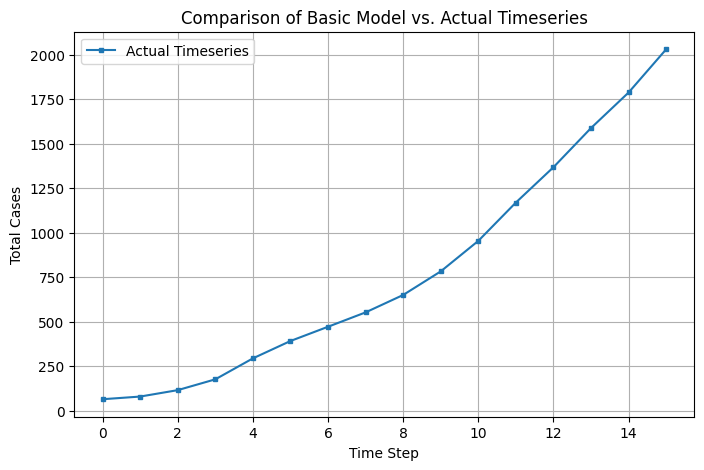

In [13]:
# Plot error for the whole city with basic method
extracted_sol = np.transpose(sol, (1, 2, 0))[2]

total_model_timeseries = np.sum(extracted_sol,axis=0)
total_timeseries = np.sum(all_station_timeseries,axis=0)
print(total_model_timeseries.shape,total_timeseries.shape)

# Plot the two time series against each other
plt.figure(figsize=(8, 5))
# plt.plot(total_model_timeseries, label="Basic Model Timeseries", linestyle='-', marker='o', markersize=3)
plt.plot(total_timeseries, label="Actual Timeseries", linestyle='-', marker='s', markersize=3)

# Labels and legend
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.title("Comparison of Basic Model vs. Actual Timeseries")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

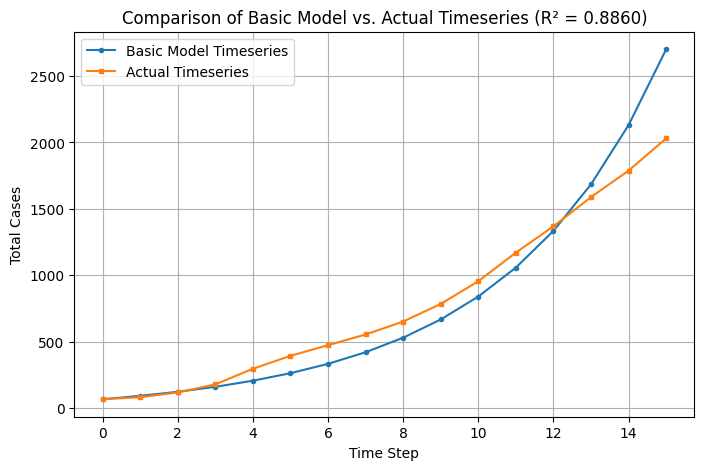

In [15]:
from sklearn.metrics import r2_score

# Compute R-squared
r2 = r2_score(total_timeseries, total_model_timeseries)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(total_model_timeseries, label="Basic Model Timeseries", linestyle='-', marker='o', markersize=3)
plt.plot(total_timeseries, label="Actual Timeseries", linestyle='-', marker='s', markersize=3)

plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.title(f"Comparison of Basic Model vs. Actual Timeseries (R² = {r2:.4f})")
plt.legend()
plt.grid(True)
plt.show()


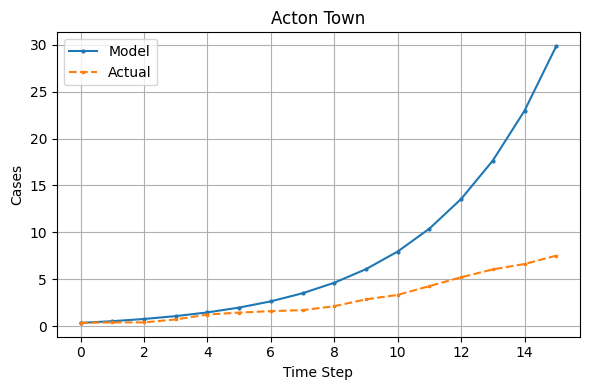

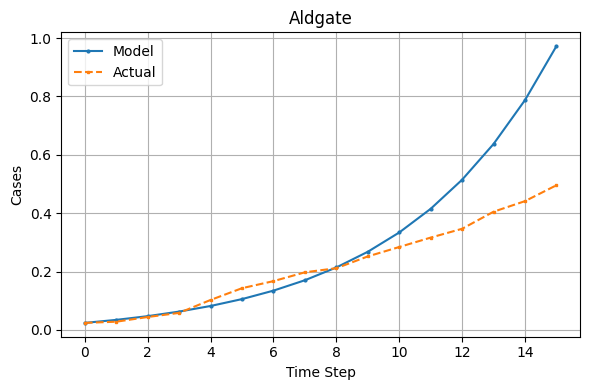

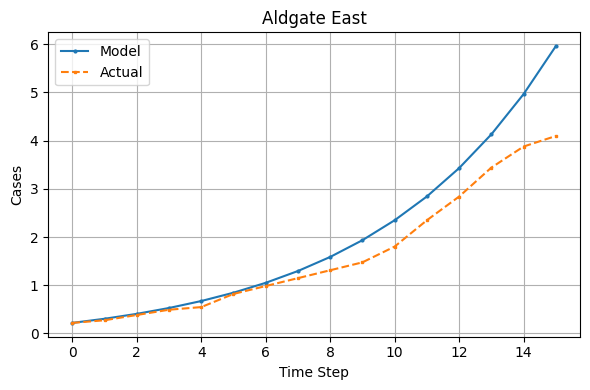

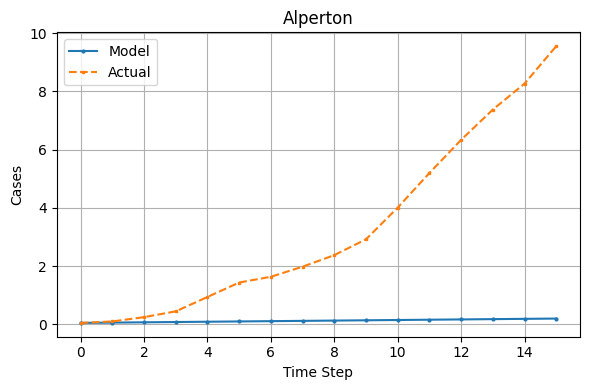

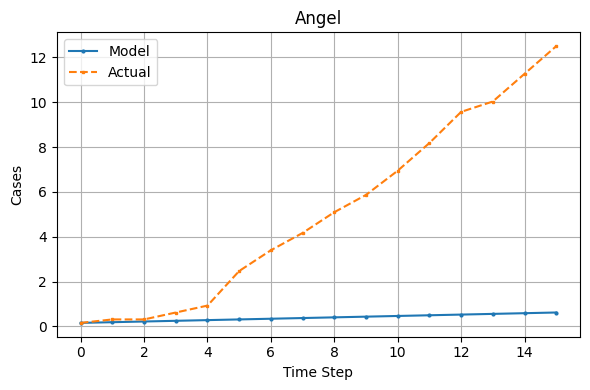

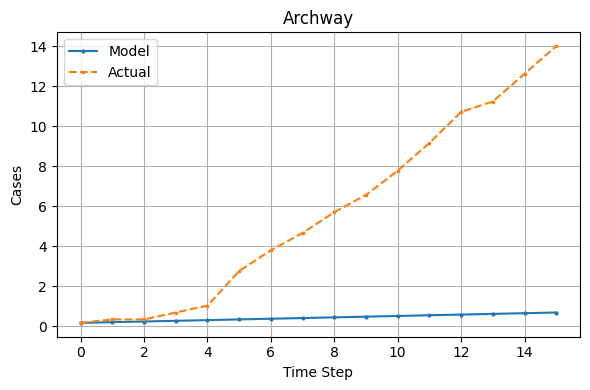

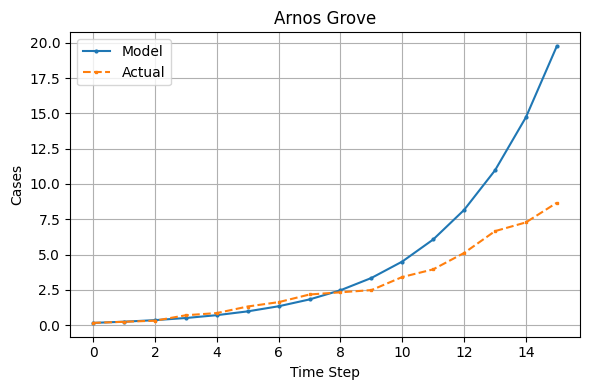

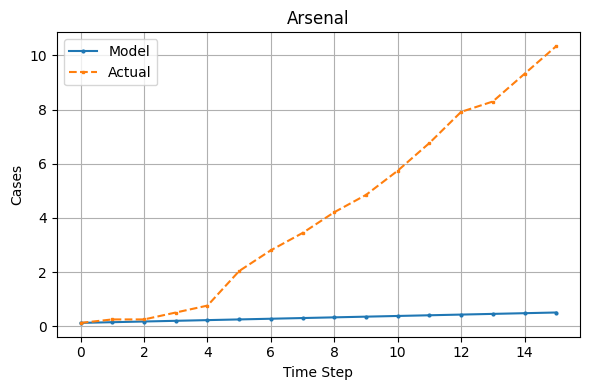

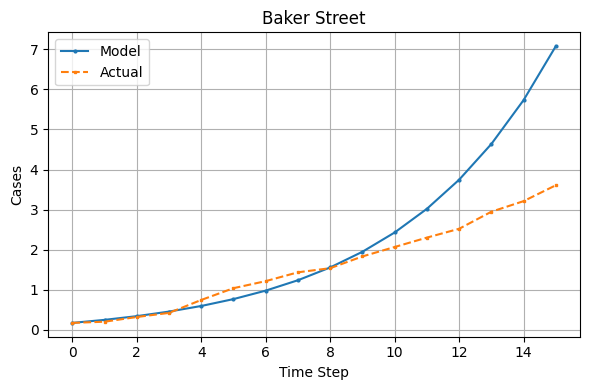

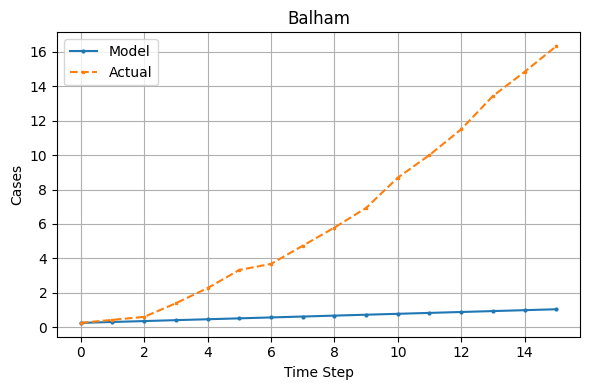

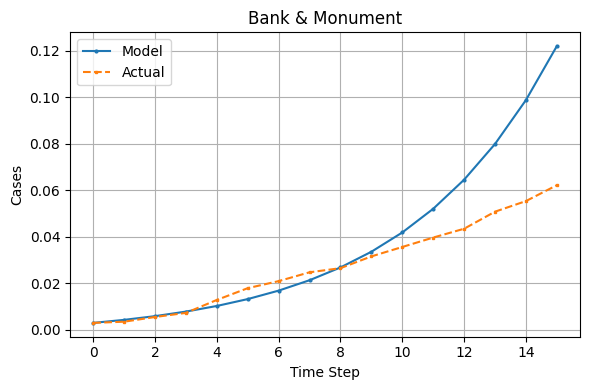

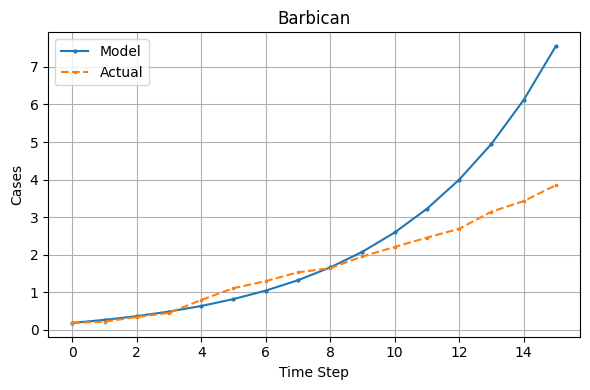

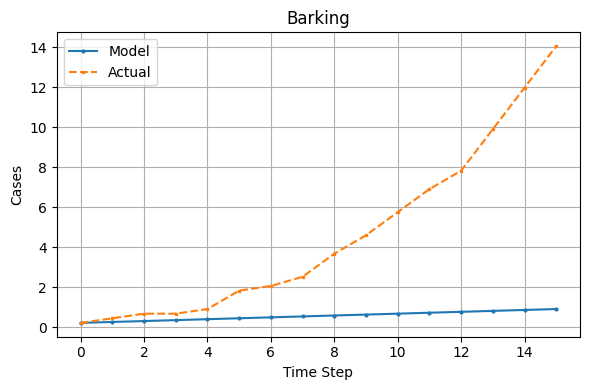

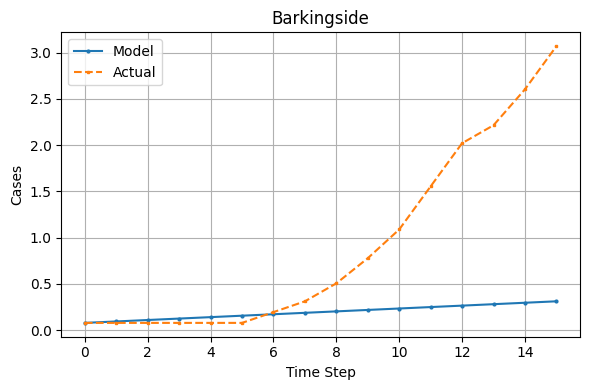

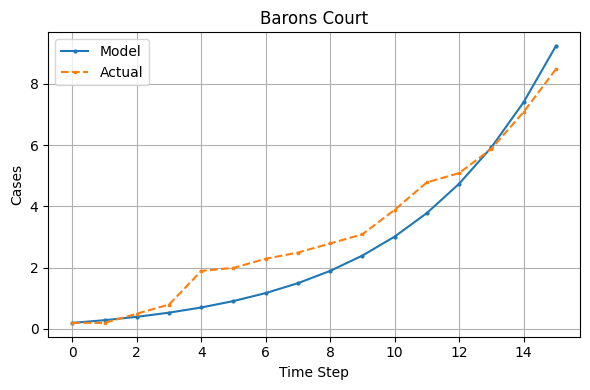

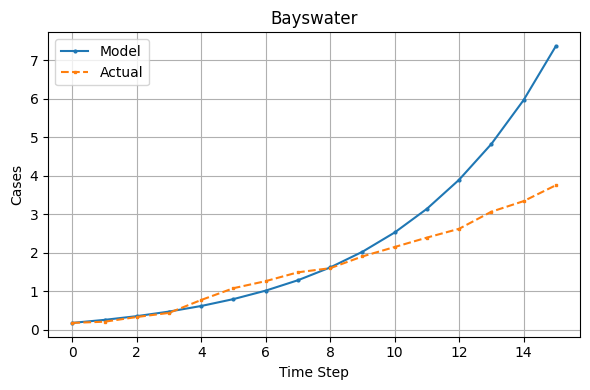

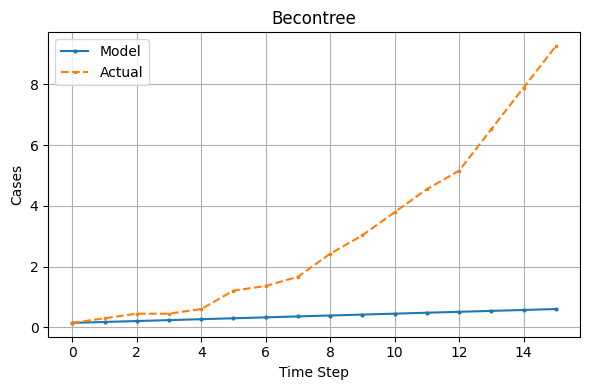

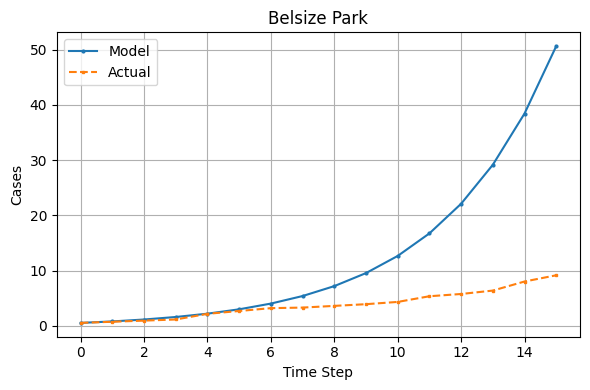

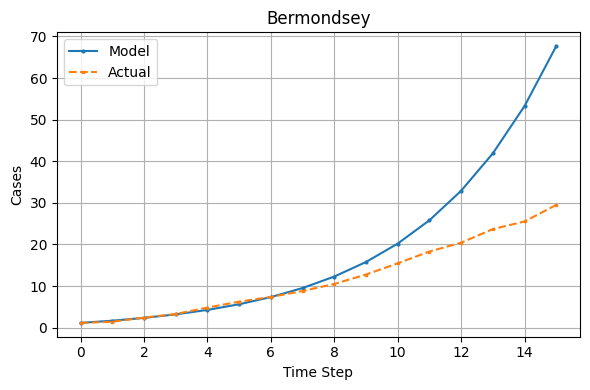

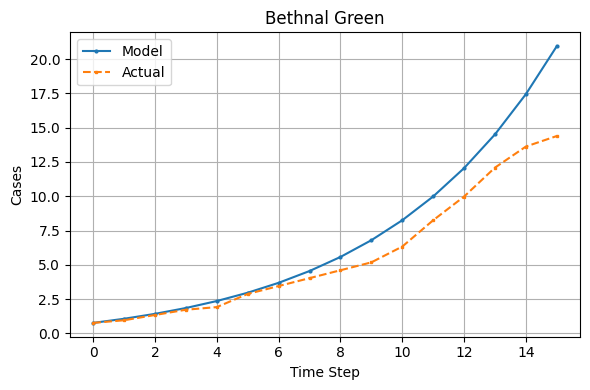

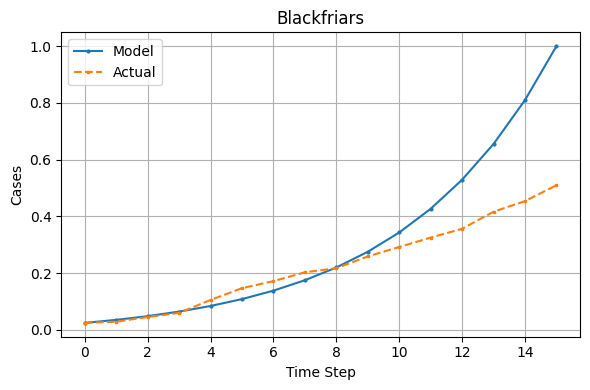

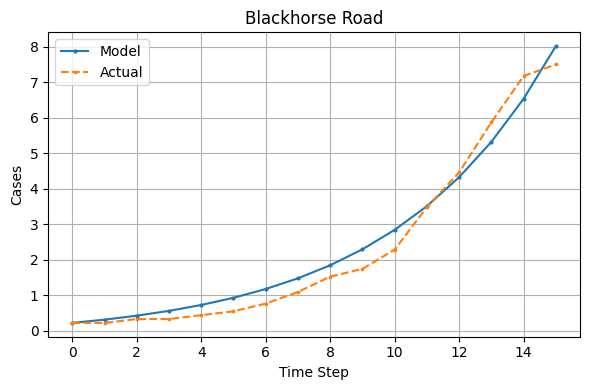

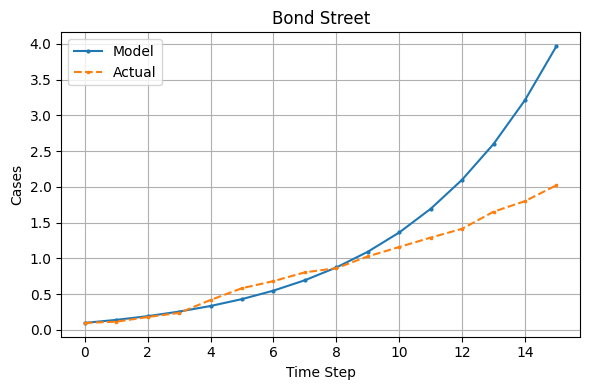

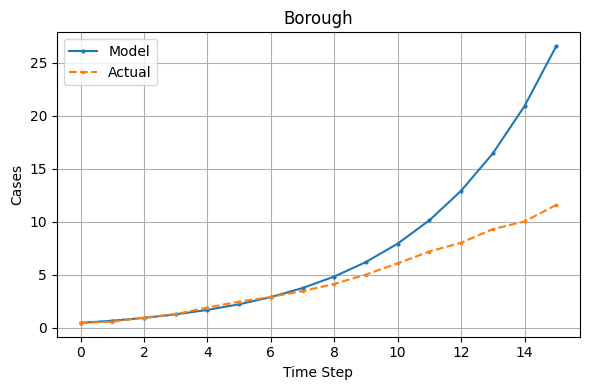

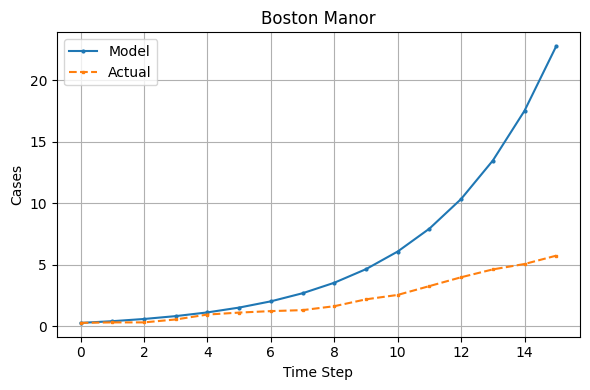

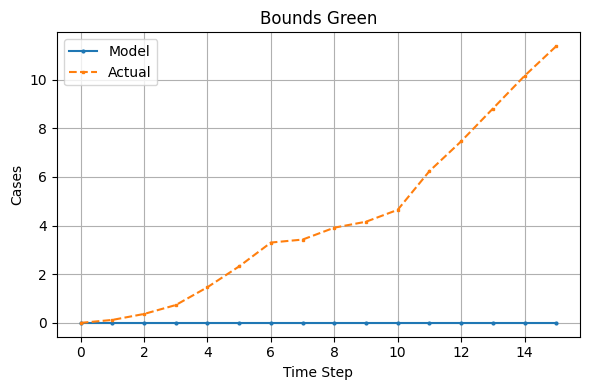

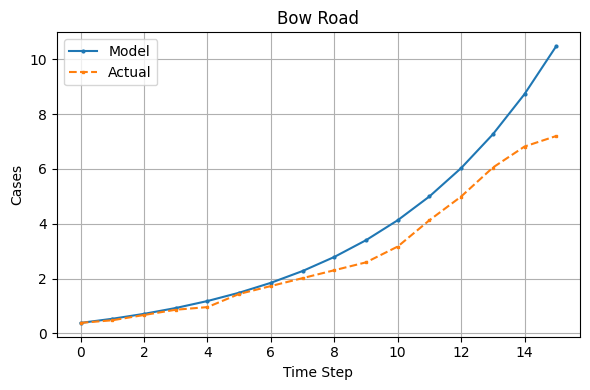

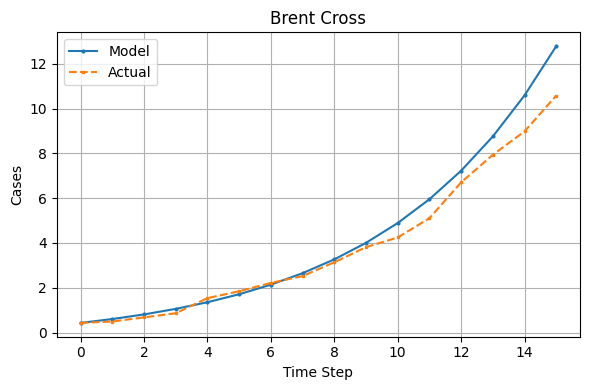

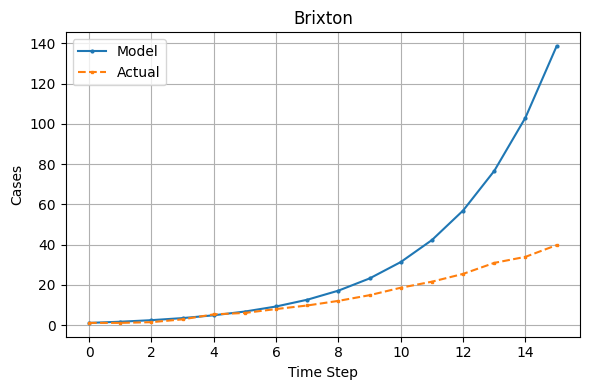

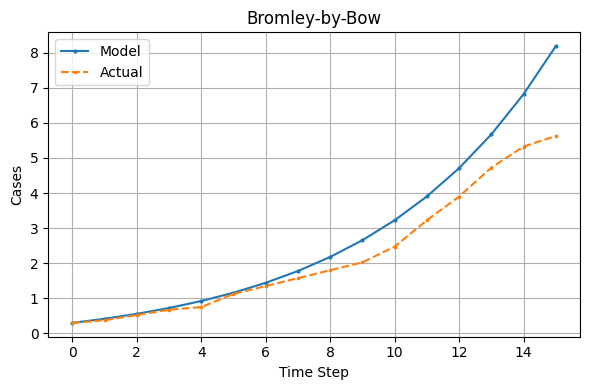

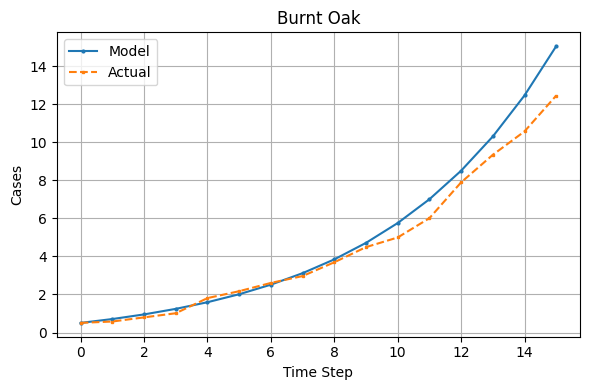

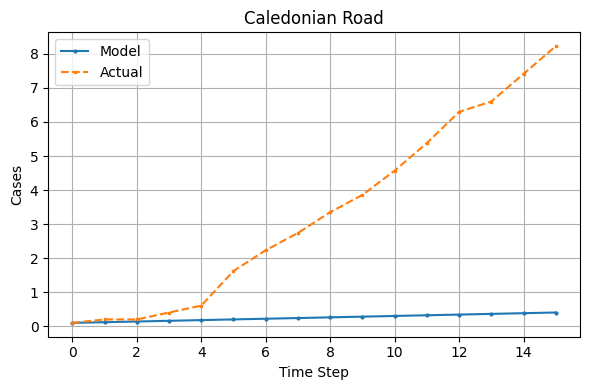

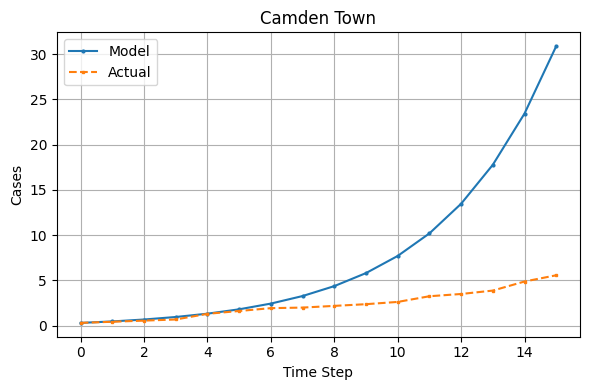

KeyboardInterrupt: 

In [251]:
extracted_sol = np.transpose(sol, (1, 2, 0))[2]  # shape: (num_indices, num_timesteps)
num_indices = extracted_sol.shape[0]

for i in range(num_indices):
    model_ts = extracted_sol[i]
    actual_ts = all_station_timeseries[i]

    plt.figure(figsize=(6, 4))
    plt.plot(model_ts, label="Model", linestyle='-', marker='o', markersize=2)
    plt.plot(actual_ts, label="Actual", linestyle='--', marker='s', markersize=2)

    plt.xlabel("Time Step")
    plt.ylabel("Cases")
    plt.title(f"{station_list[i]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [34]:
with open("London Station Borough List.pkl", "rb") as file:
    station_borough_list = pickle.load(file)
    
station_borough_list

array(['Ealing', 'Westminster,City of London', 'Tower Hamlets', 'Brent',
       'Islington', 'Islington', 'Enfield', 'Islington',
       'Westminster,City of London', 'Wandsworth',
       'Westminster,City of London', 'Westminster,City of London',
       'Barking & Dagenham', 'Redbridge', 'Hammersmith & Fulham',
       'Westminster,City of London', 'Barking & Dagenham', 'Camden',
       'Southwark', 'Tower Hamlets', 'Westminster,City of London',
       'Waltham Forest', 'Westminster,City of London', 'Southwark',
       'Ealing', 'Haringey', 'Tower Hamlets', 'Barnet', 'Lambeth',
       'Tower Hamlets', 'Barnet', 'Islington', 'Camden', 'Southwark',
       'Tower Hamlets', 'Newham', 'Westminster,City of London', 'Harrow',
       'Camden', 'Westminster,City of London',
       'Westminster,City of London', 'Redbridge', 'Ealing', 'Lambeth',
       'Lambeth', 'Wandsworth', 'Enfield', 'Barnet', 'Merton',
       'Westminster,City of London', 'Hillingdon', 'Barking & Dagenham',
       'Barking &

(16, 63002)


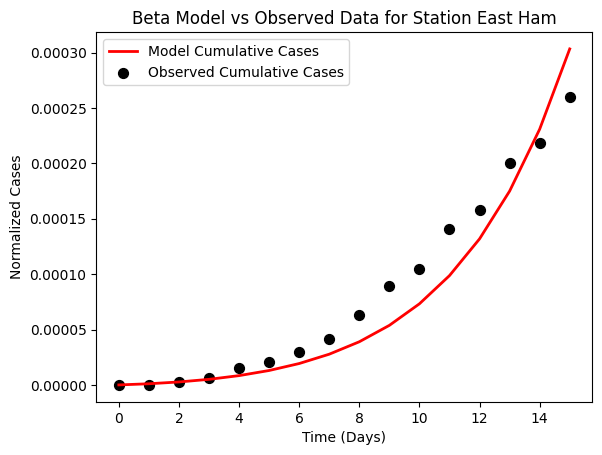

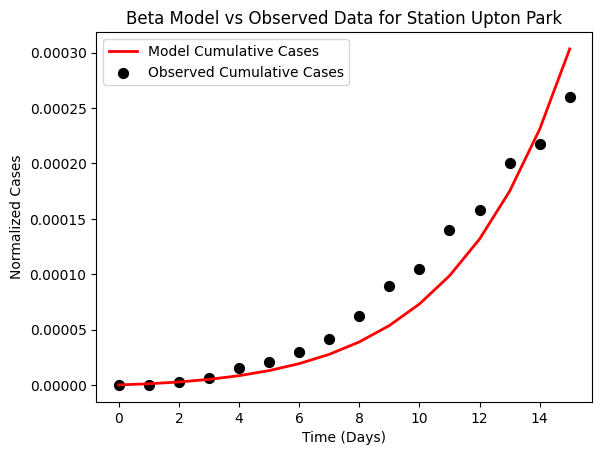

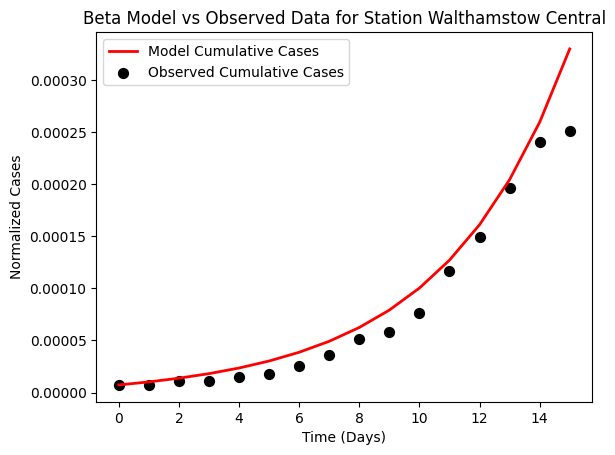

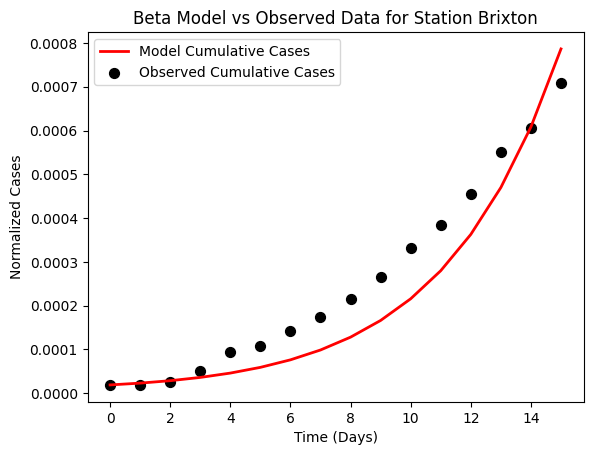

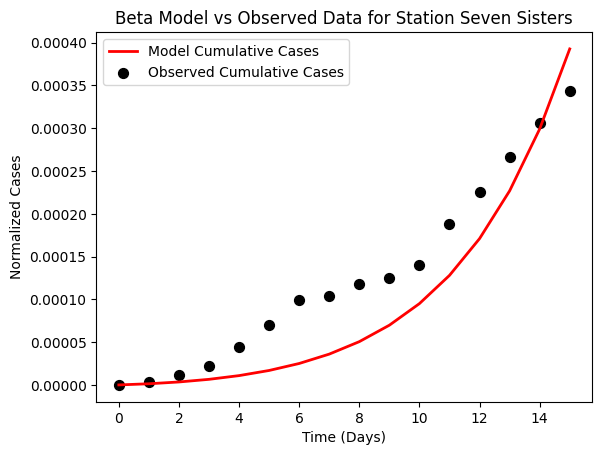

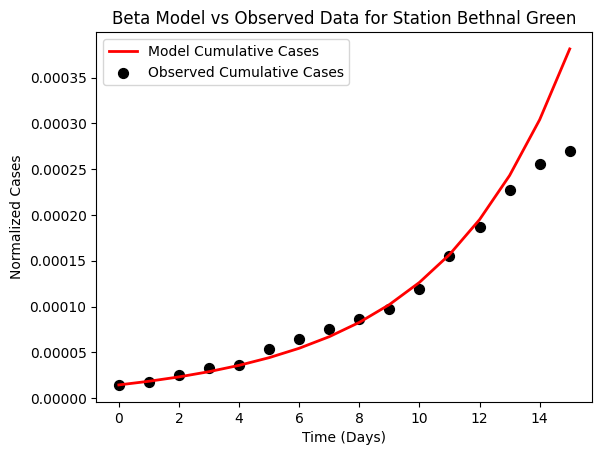

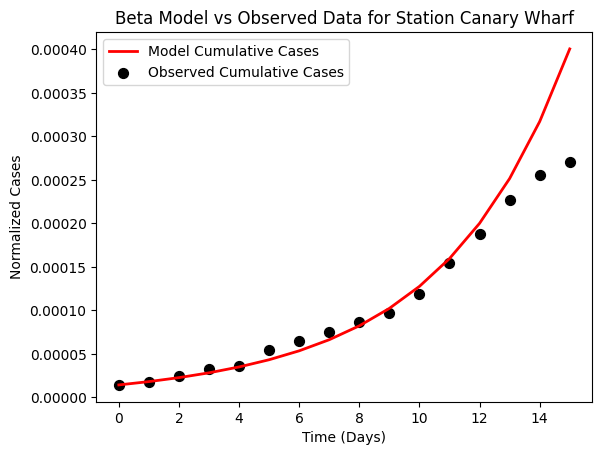

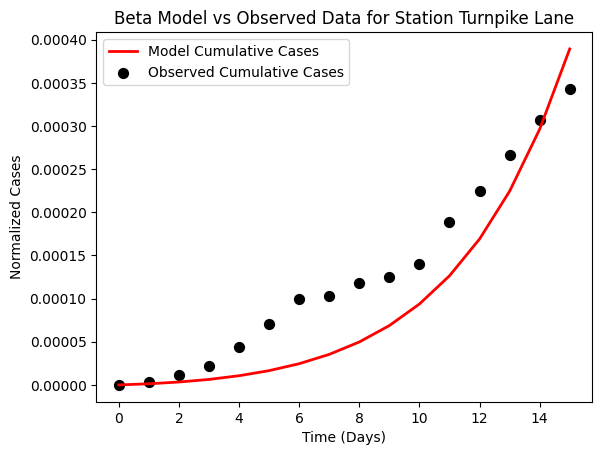

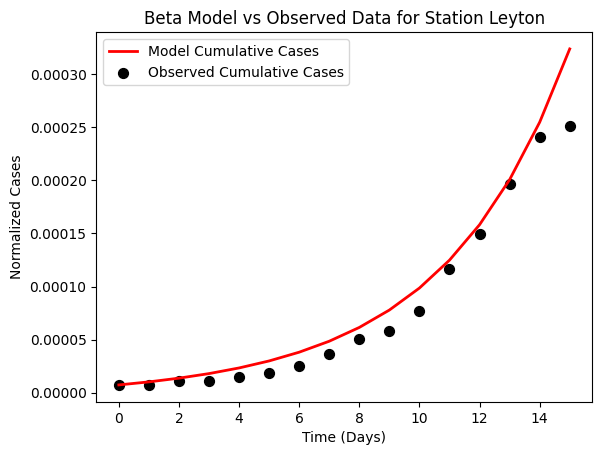

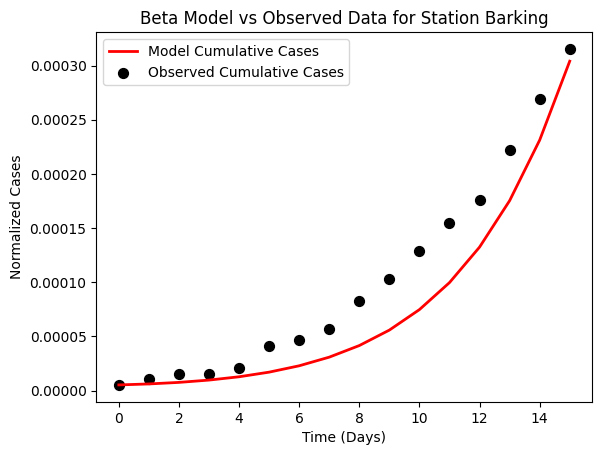

In [16]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

travel_patches = []
for i in valid_patch_indices:
    if i not in home_patches:
        travel_patches.append(i)
        
def make_detailed_beta(short_beta):
    new_beta_0 = np.zeros(837)

    for i in range(251):
        new_beta_0[i] = short_beta[i]
    for i in range(837-251):
        new_beta_0[i+251] = short_beta[-1]
    return np.array(new_beta_0)

def expand_detailed_beta(detailed_beta):
    big_beta = np.zeros(63001)
    home_betas = detailed_beta[:251]
    travel_betas = detailed_beta[251:]
    big_beta[home_patches] = home_betas
    big_beta[travel_patches] = travel_betas
    
    return big_beta

# Load best beta values
with open("Distributed Updated Formalized London Beta.pkl", "rb") as file:
    best_beta_yet_0 = pickle.load(file)
    
def expand_concise_betas(home_patches,travel_patches,concise_beta):
    long_beta = np.zeros(63001)
    for i in range(251):
        long_beta[home_patches[i]] = concise_beta[i]
    long_beta[travel_patches] = concise_beta[-1]
    
    return long_beta
    
best_beta_yet = expand_concise_betas(home_patches,travel_patches,best_beta_yet_0)

def plot_best_beta_vs_data(full_timeseries, pop_dict):
    """
    Extracts the relevant data, runs the SIR model with best_beta_yet, 
    and plots the beta values against the corresponding observed data.

    Parameters:
        full_timeseries (array-like): The full dataset of observed values.
        pop_dict (dict): Dictionary mapping population values.
    """
     # Load data
    working_timeseries = expand_timeseries(full_timeseries,day_range)
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    
    day_list = np.arange(day_range)  # There are day_range days

    # Stack so each row is [day_index, corresponding 9 values]
    data = np.column_stack((day_list[:, None], working_timeseries))

    tspan = data[:, 0]
    timespan = tspan.shape[0] - 1
    gamma = 1 / 5

    print(data.shape)
    

    I0 = expand_array(current_cases)
    S0 = pop_vector - I0
    I_total_0 = cum_cases
    
    params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
    solution = run_model_London(params)
    y = solution[2]

    I_sum_model = compress_timeseries(y.T,day_range)
    raw_real_data = compress_timeseries(data.T[1:].T,day_range)
    normalizer = compress_array(pop_vector)[:, np.newaxis]
    test_data = I_sum_model / normalizer
    real_data = raw_real_data / normalizer

    # Get indices of the 10 stations with the highest total populations
    top_10_indices = np.argsort(-short_pop_vector)[:10]
    

    # Plot results
    for i in top_10_indices:
        plt.figure()
        plt.plot(data[:, 0], test_data[i], 'r-', linewidth=2, label='Model Cumulative Cases')
        plt.scatter(data[:, 0], real_data[i], c='k', s=50, label='Observed Cumulative Cases')

        plt.xlabel('Time (Days)')
        plt.ylabel('Normalized Cases')
        plt.title(f'Beta Model vs Observed Data for Station {station_list[i]}')
        plt.legend()
        plt.show()
        
    return np.array(solution),params

solution_model,params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)

In [4]:
import numpy as np
import pandas as pd
from collections import defaultdict

def rank_boroughs_by_infection(station_list, station_borough_list, extracted_sol, short_pop_vector):
    # Map each station to its borough
    borough_map = {station: borough for station, borough in zip(station_list, station_borough_list)}
    
    # Initialize borough time series and population trackers
    borough_time_series = defaultdict(lambda: np.zeros(extracted_sol.shape[1]))
    borough_populations = defaultdict(int)
    
    for i, station in enumerate(station_list):
        borough = borough_map[station]
        borough_time_series[borough] += extracted_sol[i]
        borough_populations[borough] += short_pop_vector[i]
    
    # Compute proportion infected time series for each borough
    borough_proportions = {
        borough: time_series / borough_populations[borough]
        for borough, time_series in borough_time_series.items()
    }
    
    # Create DataFrame and sort columns by highest infected proportion at each time step
    df = pd.DataFrame(borough_proportions)
    ranking_df = df.rank(axis=1, ascending=False, method='min')

    return df, ranking_df  # proportions, and rankings at each time step

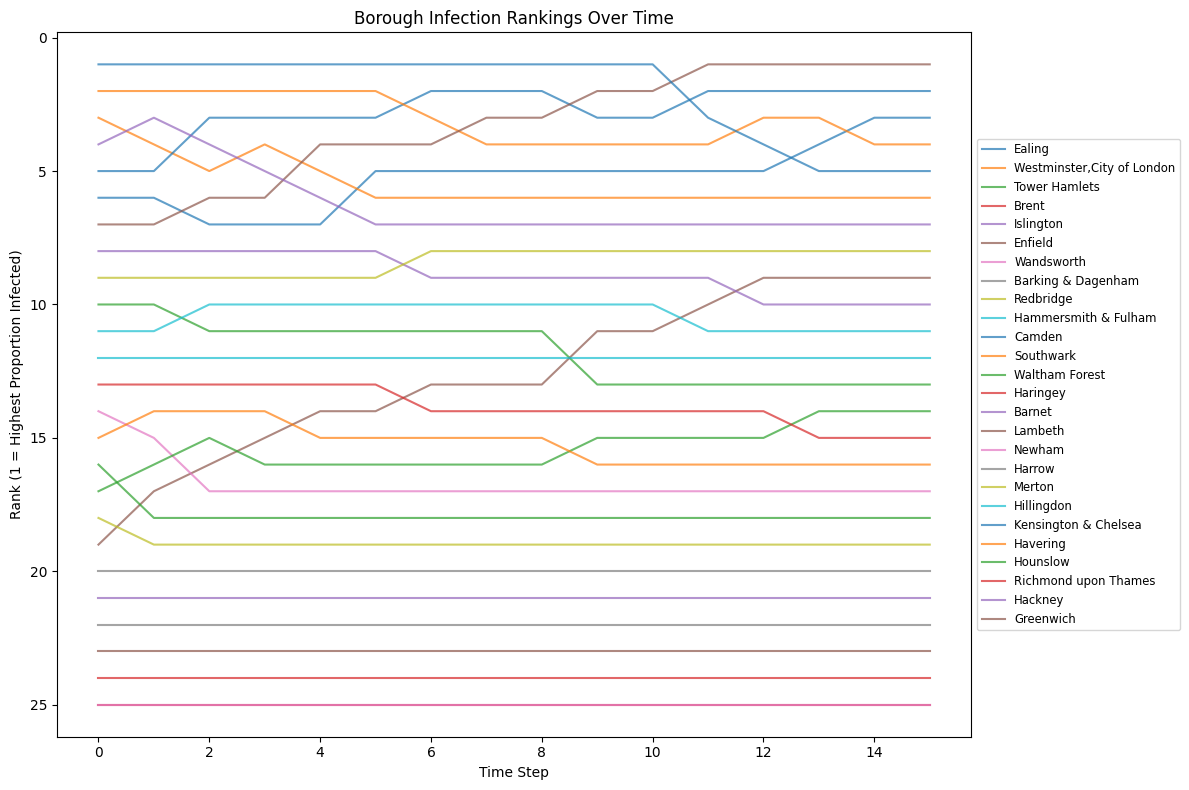

In [254]:
borough_props_sir, borough_ranks_sir = rank_boroughs_by_infection(
    station_list, station_borough_list, extracted_sol, short_pop_vector
)

plt.figure(figsize=(12, 8))
for borough in borough_ranks_sir.columns:
    plt.plot(borough_ranks_sir.index, borough_ranks_sir[borough], label=borough, alpha=0.7)

plt.gca().invert_yaxis()  # So rank 1 is at the top
plt.xlabel("Time Step")
plt.ylabel("Rank (1 = Highest Proportion Infected)")
plt.title("Borough Infection Rankings Over Time")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

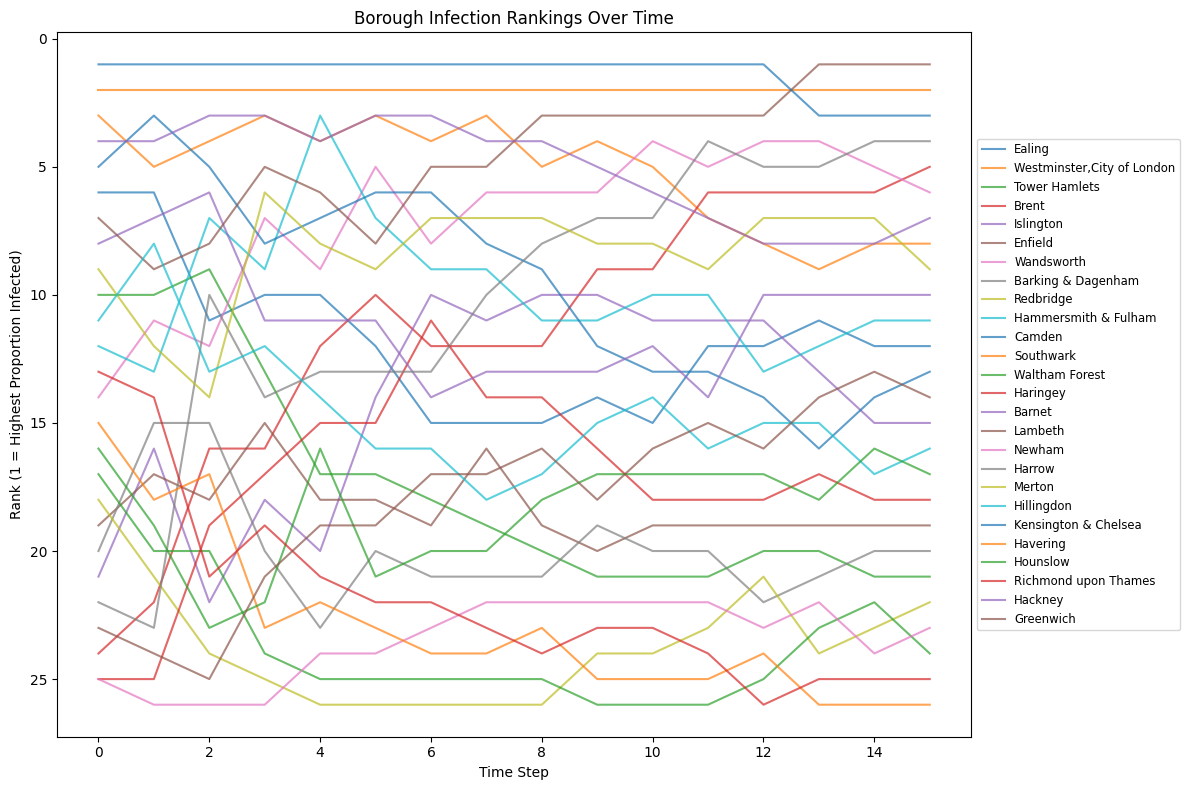

In [255]:
borough_props_data, borough_ranks_data = rank_boroughs_by_infection(
    station_list, station_borough_list, all_station_timeseries, short_pop_vector
)

plt.figure(figsize=(12, 8))
for borough in borough_ranks_data.columns:
    plt.plot(borough_ranks_data.index, borough_ranks_data[borough], label=borough, alpha=0.7)

plt.gca().invert_yaxis()  # So rank 1 is at the top
plt.xlabel("Time Step")
plt.ylabel("Rank (1 = Highest Proportion Infected)")
plt.title("Borough Infection Rankings Over Time")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

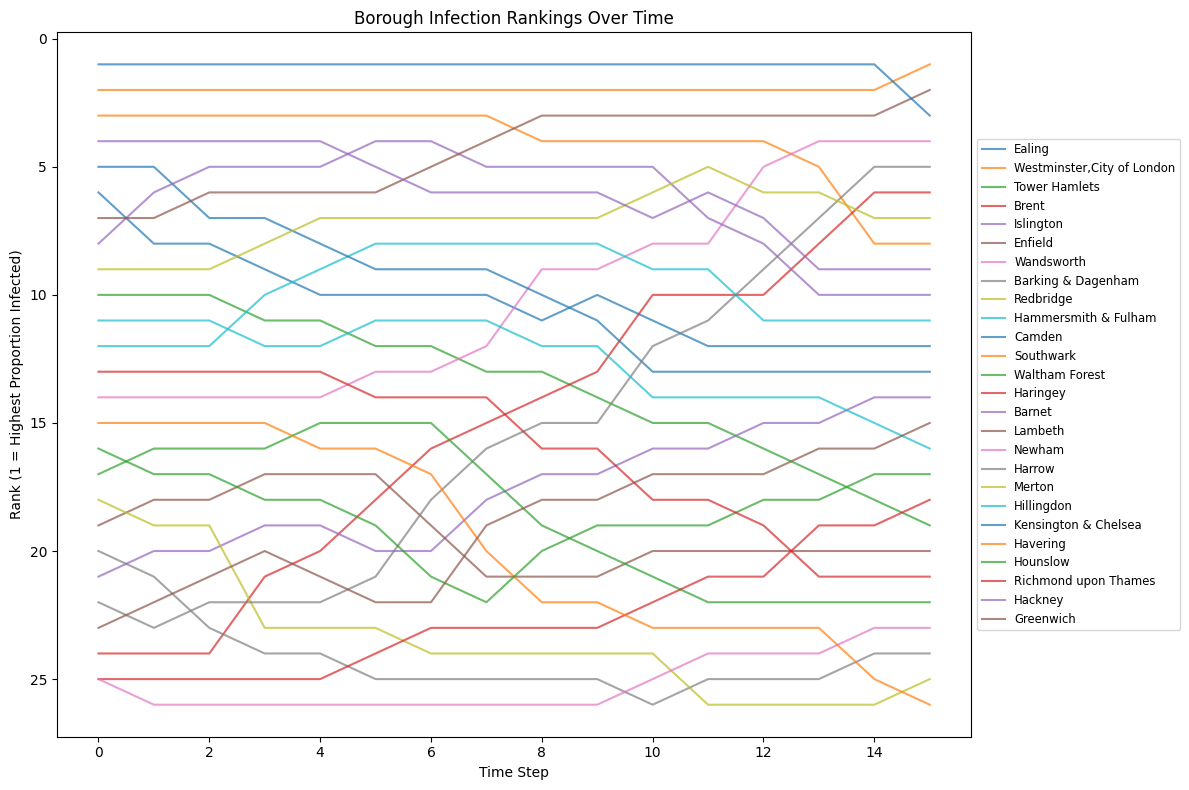

In [256]:
model_solution = solution_model[2][home_patches]

borough_props_model, borough_ranks_model = rank_boroughs_by_infection(
    station_list, station_borough_list, model_solution, short_pop_vector
)

plt.figure(figsize=(12, 8))
for borough in borough_ranks_model.columns:
    plt.plot(borough_ranks_model.index, borough_ranks_model[borough], label=borough, alpha=0.7)

plt.gca().invert_yaxis()  # So rank 1 is at the top
plt.xlabel("Time Step")
plt.ylabel("Rank (1 = Highest Proportion Infected)")
plt.title("Borough Infection Rankings Over Time")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small', ncol=1)
plt.tight_layout()
plt.show()

In [132]:
borough_ranks_model

,Ealing,"Westminster,City of London",Tower Hamlets,Brent,Islington,Enfield,Wandsworth,Barking & Dagenham,Redbridge,Hammersmith & Fulham,...,Newham,Harrow,Merton,Hillingdon,Kensington & Chelsea,Havering,Hounslow,Richmond upon Thames,Hackney,Greenwich
0,6.0,3.0,10.0,24.0,21.0,19.0,14.0,20.0,18.0,12.0,...,25.0,22.0,9.0,11.0,1.0,15.0,16.0,13.0,4.0,23.0
1,8.0,3.0,10.0,24.0,20.0,18.0,14.0,21.0,19.0,12.0,...,26.0,23.0,9.0,11.0,1.0,15.0,17.0,13.0,4.0,22.0
2,8.0,3.0,10.0,24.0,20.0,18.0,14.0,23.0,19.0,12.0,...,26.0,22.0,9.0,11.0,1.0,15.0,17.0,13.0,4.0,21.0
3,9.0,3.0,11.0,21.0,19.0,17.0,14.0,24.0,23.0,10.0,...,26.0,22.0,8.0,12.0,1.0,15.0,18.0,13.0,4.0,20.0
4,9.0,3.0,11.0,20.0,19.0,17.0,14.0,24.0,23.0,10.0,...,26.0,22.0,7.0,12.0,1.0,16.0,18.0,13.0,4.0,21.0
5,10.0,3.0,12.0,18.0,20.0,17.0,13.0,25.0,23.0,8.0,...,26.0,21.0,7.0,11.0,1.0,16.0,19.0,14.0,5.0,22.0
6,10.0,3.0,12.0,16.0,20.0,19.0,13.0,25.0,24.0,8.0,...,26.0,18.0,7.0,11.0,1.0,17.0,21.0,14.0,6.0,22.0
7,10.0,3.0,13.0,15.0,18.0,21.0,12.0,25.0,24.0,8.0,...,26.0,16.0,7.0,11.0,1.0,20.0,22.0,14.0,6.0,19.0
8,11.0,4.0,13.0,14.0,17.0,21.0,9.0,25.0,24.0,8.0,...,26.0,15.0,7.0,12.0,1.0,22.0,20.0,16.0,6.0,18.0
9,10.0,4.0,14.0,13.0,17.0,21.0,9.0,25.0,24.0,8.0,...,26.0,15.0,7.0,12.0,1.0,22.0,19.0,16.0,6.0,18.0


In [133]:
borough_ranks_data

,Ealing,"Westminster,City of London",Tower Hamlets,Brent,Islington,Enfield,Wandsworth,Barking & Dagenham,Redbridge,Hammersmith & Fulham,...,Newham,Harrow,Merton,Hillingdon,Kensington & Chelsea,Havering,Hounslow,Richmond upon Thames,Hackney,Greenwich
0,6.0,3.0,10.0,24.0,21.0,19.0,14.0,20.0,18.0,12.0,...,25.0,22.0,9.0,11.0,1.0,15.0,16.0,13.0,4.0,23.0
1,6.0,5.0,10.0,22.0,16.0,17.0,11.0,15.0,21.0,13.0,...,26.0,23.0,12.0,8.0,1.0,18.0,19.0,14.0,4.0,24.0
2,11.0,4.0,9.0,16.0,22.0,18.0,12.0,15.0,24.0,7.0,...,26.0,10.0,14.0,13.0,1.0,17.0,23.0,21.0,3.0,25.0
3,10.0,3.0,13.0,16.0,18.0,15.0,7.0,20.0,25.0,9.0,...,26.0,14.0,6.0,12.0,1.0,23.0,22.0,19.0,3.0,21.0
4,10.0,4.0,17.0,12.0,20.0,18.0,9.0,23.0,26.0,3.0,...,24.0,13.0,8.0,14.0,1.0,22.0,16.0,21.0,4.0,19.0
5,12.0,3.0,17.0,10.0,14.0,18.0,5.0,20.0,26.0,7.0,...,24.0,13.0,9.0,16.0,1.0,23.0,21.0,22.0,3.0,19.0
6,15.0,4.0,18.0,12.0,10.0,19.0,8.0,21.0,26.0,9.0,...,23.0,13.0,7.0,16.0,1.0,24.0,20.0,22.0,3.0,17.0
7,15.0,3.0,19.0,12.0,11.0,16.0,6.0,21.0,26.0,9.0,...,22.0,10.0,7.0,18.0,1.0,24.0,20.0,23.0,4.0,17.0
8,15.0,5.0,20.0,12.0,10.0,19.0,6.0,21.0,26.0,11.0,...,22.0,8.0,7.0,17.0,1.0,23.0,18.0,24.0,4.0,16.0
9,14.0,4.0,21.0,9.0,10.0,20.0,6.0,19.0,24.0,11.0,...,22.0,7.0,8.0,15.0,1.0,25.0,17.0,23.0,5.0,18.0


In [134]:
borough_ranks_sir

,Ealing,"Westminster,City of London",Tower Hamlets,Brent,Islington,Enfield,Wandsworth,Barking & Dagenham,Redbridge,Hammersmith & Fulham,...,Newham,Harrow,Merton,Hillingdon,Kensington & Chelsea,Havering,Hounslow,Richmond upon Thames,Hackney,Greenwich
0,6.0,3.0,10.0,24.0,21.0,19.0,14.0,20.0,18.0,12.0,...,25.0,22.0,9.0,11.0,1.0,15.0,16.0,13.0,4.0,23.0
1,6.0,4.0,10.0,24.0,21.0,17.0,15.0,20.0,19.0,12.0,...,25.0,22.0,9.0,11.0,1.0,14.0,18.0,13.0,3.0,23.0
2,7.0,5.0,11.0,24.0,21.0,16.0,17.0,20.0,19.0,12.0,...,25.0,22.0,9.0,10.0,1.0,14.0,18.0,13.0,4.0,23.0
3,7.0,4.0,11.0,24.0,21.0,15.0,17.0,20.0,19.0,12.0,...,25.0,22.0,9.0,10.0,1.0,14.0,18.0,13.0,5.0,23.0
4,7.0,5.0,11.0,24.0,21.0,14.0,17.0,20.0,19.0,12.0,...,25.0,22.0,9.0,10.0,1.0,15.0,18.0,13.0,6.0,23.0
5,5.0,6.0,11.0,24.0,21.0,14.0,17.0,20.0,19.0,12.0,...,25.0,22.0,9.0,10.0,1.0,15.0,18.0,13.0,7.0,23.0
6,5.0,6.0,11.0,24.0,21.0,13.0,17.0,20.0,19.0,12.0,...,25.0,22.0,8.0,10.0,1.0,15.0,18.0,14.0,7.0,23.0
7,5.0,6.0,11.0,24.0,21.0,13.0,17.0,20.0,19.0,12.0,...,25.0,22.0,8.0,10.0,1.0,15.0,18.0,14.0,7.0,23.0
8,5.0,6.0,11.0,24.0,21.0,13.0,17.0,20.0,19.0,12.0,...,25.0,22.0,8.0,10.0,1.0,15.0,18.0,14.0,7.0,23.0
9,5.0,6.0,13.0,24.0,21.0,11.0,17.0,20.0,19.0,12.0,...,25.0,22.0,8.0,10.0,1.0,16.0,18.0,14.0,7.0,23.0


In [135]:
np.array(borough_ranks_data)

array([[ 6.,  3., 10., ..., 13.,  4., 23.],
       [ 6.,  5., 10., ..., 14.,  4., 24.],
       [11.,  4.,  9., ..., 21.,  3., 25.],
       ...,
       [ 7., 18., 23., ..., 25., 18., 17.],
       [ 7., 20., 23., ..., 24., 20., 18.],
       [ 8., 21., 23., ..., 25., 22., 17.]])

In [3]:
from scipy.stats import kendalltau

true = np.array(borough_ranks_data)      # bob, billy, david
model1 = np.array(borough_ranks_sir)    # billy, bob, david
model2 = np.array(borough_ranks_model)    # david, billy, bob

tau1, _ = kendalltau(true, model1)
tau2, _ = kendalltau(true, model2)

print(tau1, tau2)  # higher value = better ranking


NameError: name 'borough_ranks_data' is not defined

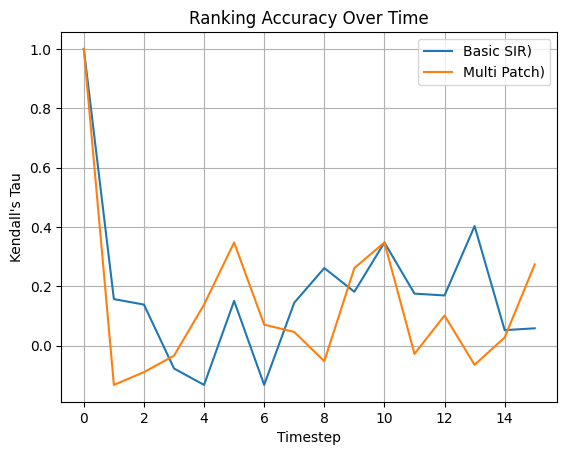

In [257]:
import numpy as np
from scipy.stats import kendalltau
import matplotlib.pyplot as plt

# Assuming shapes: (timesteps, boroughs)
true = np.array(borough_ranks_data)
model1 = np.array(borough_ranks_sir)
model2 = np.array(borough_ranks_model)

tau_scores_1 = []
tau_scores_2 = []

for t in range(true.shape[0]):
    # Get values at timestep t
    true_t = true[t]
    model1_t = model1[t]
    model2_t = model2[t]

    # Get ranks (higher value = higher rank)
    true_rank = np.argsort(-true_t)
    model1_rank = np.argsort(-model1_t)
    model2_rank = np.argsort(-model2_t)

    tau1, _ = kendalltau(true_rank, model1_rank)
    tau2, _ = kendalltau(true_rank, model2_rank)

    tau_scores_1.append(tau1)
    tau_scores_2.append(tau2)

# Plot
plt.plot(tau_scores_1, label='Basic SIR)')
plt.plot(tau_scores_2, label='Multi Patch)')
plt.xlabel('Timestep')
plt.ylabel("Kendall's Tau")
plt.title("Ranking Accuracy Over Time")
plt.legend()
plt.grid(True)
plt.show()


In [169]:
all_station_timeseries_old = all_station_timeseries.copy()

In [170]:
import numpy as np

def compute_active_cases(all_station_timeseries, infectious_period=5):
    # Ensure input is a NumPy array
    data = np.asarray(all_station_timeseries)
    
    # Compute new array: active cases = cumulative - cumulative from (t - infectious_period)
    active_cases = data - np.roll(data, infectious_period, axis=1)
    
    # Zero out first `infectious_period` columns (since they use rolled-over values)
    active_cases[:, :infectious_period] = data[:, :infectious_period]
    
    return active_cases

all_station_timeseries = compute_active_cases(all_station_timeseries)

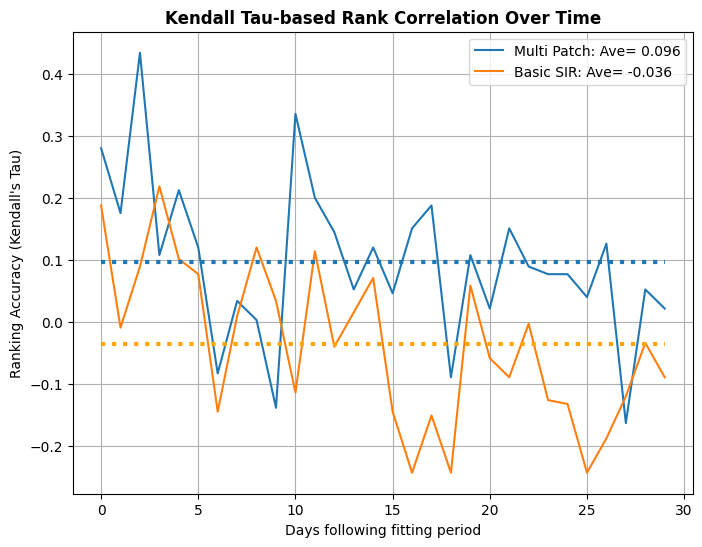

In [14]:
def make_taus(timesteps):
    day_range = timesteps
    def expand_array(short_array):
        long_array = np.zeros(63001)  # Create a zero array of the desired size

        # Assign values at the correct positions
        long_array[np.arange(251) * (251 + 1)] = short_array
        return long_array

    def compress_timeseries(long_timeseries,timespan=day_range):
        compressed = np.zeros((timespan, 251))  # Adjusted to match the original short array shape

        for i in range(timespan):
            compressed[i] = compress_array(long_timeseries[i])

        return compressed.T  # Transpose back to match original input shape

    def compress_array(long_array):
        return long_array[np.arange(251) * (251 + 1)]  # Extract values from the expanded positions



    # Load dictionary
    with open("Proper_London_Patch_Populations_1_5km_fixed.pkl", "rb") as file:
        pop_dict = pickle.load(file)

    # Extract values in order
    short_pop_vector = np.array(list(pop_dict.values()))

    pop_vector = expand_array(short_pop_vector)

    with open("London Borough List.pkl", 'rb') as f:
        borough_list = pickle.load(f)

    with open("London Station List.pkl", "rb") as file:
        station_list = pickle.load(file)

    with open("London Station Borough List.pkl", 'rb') as f:
        station_borough_list = pickle.load(f)

    with open("Proper London Station Borough Proportions Dict.pkl", 'rb') as f:
        props_dict = pickle.load(f)

    with open("London Home Patch Indices.pkl", "rb") as file:
        home_patches = pickle.load(file)

    with open("London Unique Patches.pkl", 'rb') as f:
        valid_patches = pickle.load(f)

    with open("London Valid Patch Indices.pkl", 'rb') as f:
        valid_patch_indices = pickle.load(f)

    # Load files
    with open("Sparse London P Matrix.pkl", "rb") as file:
        sparse_p = pickle.load(file)

    p_matrix = sparse_p.toarray()
    Nj = pop_vector @ p_matrix


    covid_df = pd.read_csv("phe_cases_london_boroughs_fixed.csv")
    covid_df['date'] = pd.to_datetime(covid_df['date'])


    ################################################################################################
    ################################################################################################
    ################################################################################################
    ################################################################################################

    def get_timeseries(station_name,covid_df,props_dict):

        current_borough = props_dict[station_name][0]

        # Filter data for the given area_name "Lambeth" and within the maximum date range
        filtered_df = covid_df[
            (covid_df['date'] <= "2020-03-22") & 
            (covid_df['area_name'] == current_borough)
        ]

        # Find the earliest date where total_cases is nonzero
        # earliest_nonzero_date = filtered_df.loc[filtered_df['total_cases'] > 0, 'date'].min()
        earliest_nonzero_date = "2020-03-07"

        # Filter again using the adjusted start date
        filtered_df = filtered_df[
            (filtered_df['date'] >= earliest_nonzero_date) & 
            (filtered_df['date'] <= "2020-03-07")
        ]

        borough_timeseries = np.array(list(filtered_df['total_cases']))

        station_timeseries = props_dict[station_name][1]*borough_timeseries




        return station_timeseries



    def get_timeseries_with_five(station_name, covid_df, props_dict):
        current_borough = props_dict[station_name][0]

        # Define the start and end dates
        earliest_nonzero_date = pd.to_datetime("2020-03-07")
        end_date = earliest_nonzero_date + pd.Timedelta(days=timesteps - 1)
        five_days_before = "2020-03-04"  # 5 days before the earliest nonzero date

        # Filter data for the given borough within the maximum date range
        filtered_df = covid_df[
            (covid_df['date'] >= earliest_nonzero_date) & 
            (covid_df['date'] <= end_date) & 
            (covid_df['area_name'] == current_borough)
        ]

        borough_timeseries = np.array(filtered_df['total_cases'])
        station_timeseries = props_dict[station_name][1] * borough_timeseries

        # Get new cases in the 5 days before the earliest nonzero date
        previous_df = covid_df[
            (covid_df['date'] >= five_days_before) & 
            (covid_df['date'] < earliest_nonzero_date) & 
            (covid_df['area_name'] == current_borough)
        ]

        total_new_cases_prev_5_days = props_dict[station_name][1]*previous_df['new_cases'].sum()

        return station_timeseries, total_new_cases_prev_5_days


    ################################################################################################
    ################################################################################################
    ################################################################################################
    ################################################################################################

    all_station_timeseries = []
    all_new_cases_prev_5_days = []
    for i in range(len(station_list)):
        timeseries = get_timeseries_with_five(station_list[i],covid_df,props_dict)
        all_station_timeseries.append(timeseries[0])
        all_new_cases_prev_5_days.append(timeseries[1])


    all_station_timeseries = np.array(all_station_timeseries)
    day_range = all_station_timeseries[0].shape[0]


    def expand_timeseries(short_timeseries,timesteps=day_range):

        transposed = short_timeseries.T

        long_timeseries = np.zeros((timesteps,63001))
        for i in range(timesteps):
            long_timeseries[i] = expand_array(transposed[i])

        long_timeseries = np.array(long_timeseries)

        return long_timeseries

    working_timeseries = expand_timeseries(all_station_timeseries)
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    day_list = np.arange(day_range)
    data = np.column_stack((day_list[:, None], working_timeseries))


    current_cases = np.array(all_new_cases_prev_5_days)
    cum_cases = data[0][1:]

    gamma = 1/5



    with open("London Home Patch Indices.pkl", "rb") as file:
        home_patches = pickle.load(file)
        
    def SIR(y,beta,gamma):
        S,I,I_total = y
        N = total_pop
        dSdt = -beta*S*I/N
        dIdt = beta*S*I/N - gamma*I
        dItotaldt = beta*S*I/N
        return np.array([dSdt,dIdt,dItotaldt])

    N = total_pop
    I0 = all_station_timeseries.T[0]
    I0_total = all_station_timeseries.T[0]
    S0 = N-I0

    beta = beta_array.copy()
    gamma = 1/5

    timesteps = all_station_timeseries.shape[1]
    sol = np.zeros([timesteps,3,251])
    sol[0] = np.array([S0,I0,I0_total])

    for i in range(timesteps-1):
        sol[i+1] = sol[i] + SIR(sol[i],beta,gamma)
        
    extracted_sol = np.transpose(sol, (1, 2, 0))[1]

    total_model_timeseries = np.sum(extracted_sol,axis=0)
    total_timeseries = np.sum(all_station_timeseries,axis=0)

    travel_patches = []
    for i in valid_patch_indices:
        if i not in home_patches:
            travel_patches.append(i)

    def make_detailed_beta(short_beta):
        new_beta_0 = np.zeros(837)

        for i in range(251):
            new_beta_0[i] = short_beta[i]
        for i in range(837-251):
            new_beta_0[i+251] = short_beta[-1]
        return np.array(new_beta_0)

    def expand_detailed_beta(detailed_beta):
        big_beta = np.zeros(63001)
        home_betas = detailed_beta[:251]
        travel_betas = detailed_beta[251:]
        big_beta[home_patches] = home_betas
        big_beta[travel_patches] = travel_betas

        return big_beta

    # Load best beta values
    with open("Distributed Updated Formalized London Beta.pkl", "rb") as file:
        best_beta_yet_0 = pickle.load(file)

    def expand_concise_betas(home_patches,travel_patches,concise_beta):
        long_beta = np.zeros(63001)
        for i in range(251):
            long_beta[home_patches[i]] = concise_beta[i]
        long_beta[travel_patches] = concise_beta[-1]

        return long_beta

    best_beta_yet = expand_concise_betas(home_patches,travel_patches,best_beta_yet_0)

    def plot_best_beta_vs_data(full_timeseries, pop_dict):
        """
        Extracts the relevant data, runs the SIR model with best_beta_yet, 
        and plots the beta values against the corresponding observed data.

        Parameters:
            full_timeseries (array-like): The full dataset of observed values.
            pop_dict (dict): Dictionary mapping population values.
        """
         # Load data
        working_timeseries = expand_timeseries(full_timeseries,day_range)

        short_pop_vector = np.array(list(pop_dict.values()))
        pop_vector = expand_array(short_pop_vector)

        day_list = np.arange(day_range)  # There are day_range days

        # Stack so each row is [day_index, corresponding 9 values]
        data = np.column_stack((day_list[:, None], working_timeseries))

        tspan = data[:, 0]
        timespan = tspan.shape[0] - 1
        gamma = 1 / 5
        


        I0 = expand_array(current_cases)
        S0 = pop_vector - I0
        I_total_0 = cum_cases

        params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
        solution = run_model_London(params)
        y = solution[1]

        I_sum_model = compress_timeseries(y.T,day_range)
        raw_real_data = compress_timeseries(data.T[1:].T,day_range)
        normalizer = compress_array(pop_vector)[:, np.newaxis]
        test_data = I_sum_model / normalizer
        real_data = raw_real_data / normalizer

        # Get indices of the 10 stations with the highest total populations
        top_10_indices = np.argsort(-short_pop_vector)[:10]


        return np.array(solution),params

    solution_model,params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
    
    borough_props_sir, borough_ranks_sir = rank_boroughs_by_infection(
        station_list, station_borough_list, extracted_sol, short_pop_vector
    )
    
    borough_props_data, borough_ranks_data = rank_boroughs_by_infection(
        station_list, station_borough_list, all_station_timeseries, short_pop_vector
    )
    
    model_solution = solution_model[2][home_patches]

    borough_props_model, borough_ranks_model = rank_boroughs_by_infection(
        station_list, station_borough_list, model_solution, short_pop_vector
    )
    # Assuming shapes: (timesteps, boroughs)
    true = np.array(borough_ranks_data)
    model1 = np.array(borough_ranks_sir)
    model2 = np.array(borough_ranks_model)

    tau_scores_1 = []
    tau_scores_2 = []

    for t in range(16, true.shape[0]):
        # Get values at timestep t
        true_t = true[t]
        model1_t = model1[t]
        model2_t = model2[t]

        # Get ranks (higher value = higher rank)
        true_rank = np.argsort(-true_t)
        model1_rank = np.argsort(-model1_t)
        model2_rank = np.argsort(-model2_t)

        tau1, _ = kendalltau(true_rank, model1_rank)
        tau2, _ = kendalltau(true_rank, model2_rank)

        tau_scores_1.append(tau1)
        tau_scores_2.append(tau2)

    # Plot
    plt.figure(figsize=(8,6))
    plt.plot(tau_scores_2, label=f'Multi Patch: Ave= {np.round(np.average(tau_scores_2),3)}')
    plt.plot(tau_scores_1, label=f'Basic SIR: Ave= {np.round(np.average(tau_scores_1),3)}')
    # Horizontal average lines (same length as original, so align correctly)
    plt.hlines(np.average(tau_scores_2), xmin=0, xmax=len(tau_scores_2)-1, 
               linestyles='dotted',linewidth=3)
    plt.hlines(np.average(tau_scores_1), xmin=0, xmax=len(tau_scores_1)-1, 
               linestyles='dotted',linewidth=3, color='orange')

    plt.xlabel('Days following fitting period')
    plt.ylabel("Ranking Accuracy (Kendall's Tau)")
    plt.title("Kendall Tau-based Rank Correlation Over Time",fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.show()

    
make_taus(46)

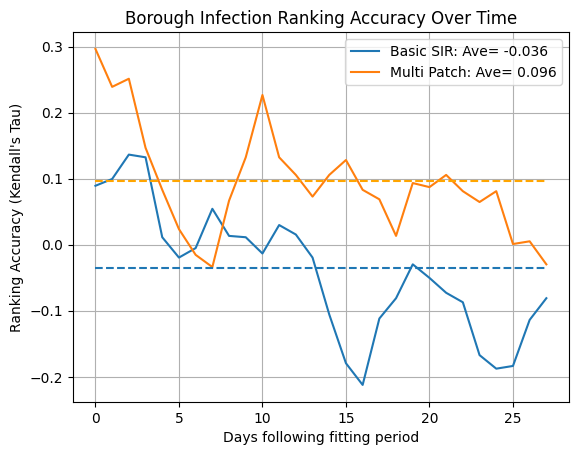

In [259]:
def make_taus(timesteps):
    day_range = timesteps
    def expand_array(short_array):
        long_array = np.zeros(63001)  # Create a zero array of the desired size

        # Assign values at the correct positions
        long_array[np.arange(251) * (251 + 1)] = short_array
        return long_array

    def compress_timeseries(long_timeseries,timespan=day_range):
        compressed = np.zeros((timespan, 251))  # Adjusted to match the original short array shape

        for i in range(timespan):
            compressed[i] = compress_array(long_timeseries[i])

        return compressed.T  # Transpose back to match original input shape

    def compress_array(long_array):
        return long_array[np.arange(251) * (251 + 1)]  # Extract values from the expanded positions



    # Load dictionary
    with open("Proper_London_Patch_Populations_1_5km_fixed.pkl", "rb") as file:
        pop_dict = pickle.load(file)

    # Extract values in order
    short_pop_vector = np.array(list(pop_dict.values()))

    pop_vector = expand_array(short_pop_vector)

    with open("London Borough List.pkl", 'rb') as f:
        borough_list = pickle.load(f)

    with open("London Station List.pkl", "rb") as file:
        station_list = pickle.load(file)

    with open("London Station Borough List.pkl", 'rb') as f:
        station_borough_list = pickle.load(f)

    with open("Proper London Station Borough Proportions Dict.pkl", 'rb') as f:
        props_dict = pickle.load(f)

    with open("London Home Patch Indices.pkl", "rb") as file:
        home_patches = pickle.load(file)

    with open("London Unique Patches.pkl", 'rb') as f:
        valid_patches = pickle.load(f)

    with open("London Valid Patch Indices.pkl", 'rb') as f:
        valid_patch_indices = pickle.load(f)

    # Load files
    with open("Sparse London P Matrix.pkl", "rb") as file:
        sparse_p = pickle.load(file)

    p_matrix = sparse_p.toarray()
    Nj = pop_vector @ p_matrix


    covid_df = pd.read_csv("phe_cases_london_boroughs_fixed.csv")
    covid_df['date'] = pd.to_datetime(covid_df['date'])


    ################################################################################################
    ################################################################################################
    ################################################################################################
    ################################################################################################

    def get_timeseries(station_name,covid_df,props_dict):

        current_borough = props_dict[station_name][0]

        # Filter data for the given area_name "Lambeth" and within the maximum date range
        filtered_df = covid_df[
            (covid_df['date'] <= "2020-03-22") & 
            (covid_df['area_name'] == current_borough)
        ]

        # Find the earliest date where total_cases is nonzero
        # earliest_nonzero_date = filtered_df.loc[filtered_df['total_cases'] > 0, 'date'].min()
        earliest_nonzero_date = "2020-03-07"

        # Filter again using the adjusted start date
        filtered_df = filtered_df[
            (filtered_df['date'] >= earliest_nonzero_date) & 
            (filtered_df['date'] <= "2020-03-07")
        ]

        borough_timeseries = np.array(list(filtered_df['total_cases']))

        station_timeseries = props_dict[station_name][1]*borough_timeseries




        return station_timeseries



    def get_timeseries_with_five(station_name, covid_df, props_dict):
        current_borough = props_dict[station_name][0]

        # Define the start and end dates
        earliest_nonzero_date = pd.to_datetime("2020-03-07")
        end_date = earliest_nonzero_date + pd.Timedelta(days=timesteps - 1)
        five_days_before = "2020-03-04"  # 5 days before the earliest nonzero date

        # Filter data for the given borough within the maximum date range
        filtered_df = covid_df[
            (covid_df['date'] >= earliest_nonzero_date) & 
            (covid_df['date'] <= end_date) & 
            (covid_df['area_name'] == current_borough)
        ]

        borough_timeseries = np.array(filtered_df['total_cases'])
        station_timeseries = props_dict[station_name][1] * borough_timeseries

        # Get new cases in the 5 days before the earliest nonzero date
        previous_df = covid_df[
            (covid_df['date'] >= five_days_before) & 
            (covid_df['date'] < earliest_nonzero_date) & 
            (covid_df['area_name'] == current_borough)
        ]

        total_new_cases_prev_5_days = props_dict[station_name][1]*previous_df['new_cases'].sum()

        return station_timeseries, total_new_cases_prev_5_days


    ################################################################################################
    ################################################################################################
    ################################################################################################
    ################################################################################################

    all_station_timeseries = []
    all_new_cases_prev_5_days = []
    for i in range(len(station_list)):
        timeseries = get_timeseries_with_five(station_list[i],covid_df,props_dict)
        all_station_timeseries.append(timeseries[0])
        all_new_cases_prev_5_days.append(timeseries[1])


    all_station_timeseries = np.array(all_station_timeseries)
    day_range = all_station_timeseries[0].shape[0]


    def expand_timeseries(short_timeseries,timesteps=day_range):

        transposed = short_timeseries.T

        long_timeseries = np.zeros((timesteps,63001))
        for i in range(timesteps):
            long_timeseries[i] = expand_array(transposed[i])

        long_timeseries = np.array(long_timeseries)

        return long_timeseries

    working_timeseries = expand_timeseries(all_station_timeseries)
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    day_list = np.arange(day_range)
    data = np.column_stack((day_list[:, None], working_timeseries))


    current_cases = np.array(all_new_cases_prev_5_days)
    cum_cases = data[0][1:]

    gamma = 1/5



    with open("London Home Patch Indices.pkl", "rb") as file:
        home_patches = pickle.load(file)
        
    def SIR(y,beta,gamma):
        S,I,I_total = y
        N = total_pop
        dSdt = -beta*S*I/N
        dIdt = beta*S*I/N - gamma*I
        dItotaldt = beta*S*I/N
        return np.array([dSdt,dIdt,dItotaldt])

    N = total_pop
    I0 = all_station_timeseries.T[0]
    I0_total = all_station_timeseries.T[0]
    S0 = N-I0

    beta = beta_array.copy()
    gamma = 1/5

    timesteps = all_station_timeseries.shape[1]
    sol = np.zeros([timesteps,3,251])
    sol[0] = np.array([S0,I0,I0_total])

    for i in range(timesteps-1):
        sol[i+1] = sol[i] + SIR(sol[i],beta,gamma)
        
    extracted_sol = np.transpose(sol, (1, 2, 0))[1]

    total_model_timeseries = np.sum(extracted_sol,axis=0)
    total_timeseries = np.sum(all_station_timeseries,axis=0)

    travel_patches = []
    for i in valid_patch_indices:
        if i not in home_patches:
            travel_patches.append(i)

    def make_detailed_beta(short_beta):
        new_beta_0 = np.zeros(837)

        for i in range(251):
            new_beta_0[i] = short_beta[i]
        for i in range(837-251):
            new_beta_0[i+251] = short_beta[-1]
        return np.array(new_beta_0)

    def expand_detailed_beta(detailed_beta):
        big_beta = np.zeros(63001)
        home_betas = detailed_beta[:251]
        travel_betas = detailed_beta[251:]
        big_beta[home_patches] = home_betas
        big_beta[travel_patches] = travel_betas

        return big_beta

    # Load best beta values
    with open("Distributed Updated Formalized London Beta.pkl", "rb") as file:
        best_beta_yet_0 = pickle.load(file)

    def expand_concise_betas(home_patches,travel_patches,concise_beta):
        long_beta = np.zeros(63001)
        for i in range(251):
            long_beta[home_patches[i]] = concise_beta[i]
        long_beta[travel_patches] = concise_beta[-1]

        return long_beta

    best_beta_yet = expand_concise_betas(home_patches,travel_patches,best_beta_yet_0)

    def plot_best_beta_vs_data(full_timeseries, pop_dict):
        """
        Extracts the relevant data, runs the SIR model with best_beta_yet, 
        and plots the beta values against the corresponding observed data.

        Parameters:
            full_timeseries (array-like): The full dataset of observed values.
            pop_dict (dict): Dictionary mapping population values.
        """
         # Load data
        working_timeseries = expand_timeseries(full_timeseries,day_range)

        short_pop_vector = np.array(list(pop_dict.values()))
        pop_vector = expand_array(short_pop_vector)

        day_list = np.arange(day_range)  # There are day_range days

        # Stack so each row is [day_index, corresponding 9 values]
        data = np.column_stack((day_list[:, None], working_timeseries))

        tspan = data[:, 0]
        timespan = tspan.shape[0] - 1
        gamma = 1 / 5
        


        I0 = expand_array(current_cases)
        S0 = pop_vector - I0
        I_total_0 = cum_cases

        params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
        solution = run_model_London(params)
        y = solution[1]

        I_sum_model = compress_timeseries(y.T,day_range)
        raw_real_data = compress_timeseries(data.T[1:].T,day_range)
        normalizer = compress_array(pop_vector)[:, np.newaxis]
        test_data = I_sum_model / normalizer
        real_data = raw_real_data / normalizer

        # Get indices of the 10 stations with the highest total populations
        top_10_indices = np.argsort(-short_pop_vector)[:10]


        return np.array(solution),params

    solution_model,params = plot_best_beta_vs_data(all_station_timeseries, pop_dict)
    
    borough_props_sir, borough_ranks_sir = rank_boroughs_by_infection(
        station_list, station_borough_list, extracted_sol, short_pop_vector
    )
    
    borough_props_data, borough_ranks_data = rank_boroughs_by_infection(
        station_list, station_borough_list, all_station_timeseries, short_pop_vector
    )
    
    model_solution = solution_model[2][home_patches]

    borough_props_model, borough_ranks_model = rank_boroughs_by_infection(
        station_list, station_borough_list, model_solution, short_pop_vector
    )
    # Assuming shapes: (timesteps, boroughs)
    true = np.array(borough_ranks_data)
    model1 = np.array(borough_ranks_sir)
    model2 = np.array(borough_ranks_model)

    tau_scores_1 = []
    tau_scores_2 = []
    

    for t in range(16, true.shape[0]):
        # Get values at timestep t
        true_t = true[t]
        model1_t = model1[t]
        model2_t = model2[t]

        # Get ranks (higher value = higher rank)
        true_rank = np.argsort(-true_t)
        model1_rank = np.argsort(-model1_t)
        model2_rank = np.argsort(-model2_t)

        tau1, _ = kendalltau(true_rank, model1_rank)
        tau2, _ = kendalltau(true_rank, model2_rank)

        tau_scores_1.append(tau1)
        tau_scores_2.append(tau2)
        
    def moving_average(x, w=3):
        return np.convolve(x, np.ones(w)/w, mode='valid')

    smoothed_tau_1 = moving_average(tau_scores_1, w=3)
    smoothed_tau_2 = moving_average(tau_scores_2, w=3)


    # Plot
    plt.plot(smoothed_tau_1, label=f'Basic SIR: Ave= {np.round(np.average(tau_scores_1),3)}')
    plt.plot(smoothed_tau_2, label=f'Multi Patch: Ave= {np.round(np.average(tau_scores_2),3)}')
    # Horizontal average lines (same length as original, so align correctly)
    plt.hlines(np.average(tau_scores_1), xmin=0, xmax=len(smoothed_tau_1)-1, 
               linestyles='dashed')

    plt.hlines(np.average(tau_scores_2), xmin=0, xmax=len(smoothed_tau_2)-1, 
               linestyles='dashed', colors='orange')

    plt.xlabel('Days following fitting period')
    plt.ylabel("Ranking Accuracy (Kendall's Tau)")
    plt.title("Borough Infection Ranking Accuracy Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    
make_taus(46)

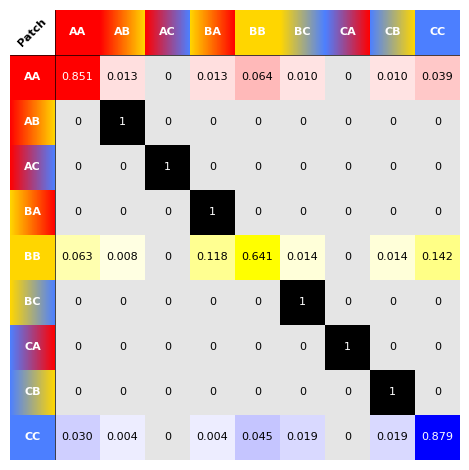

In [222]:
import numpy as np
import matplotlib.pyplot as plt

# Define the matrix
P = np.array([
    [0.851, 0.013, 0,     0.013, 0.064, 0.010, 0,     0.010, 0.039],
    [0,     1,     0,     0,     0,     0,     0,     0,     0    ],
    [0,     0,     1,     0,     0,     0,     0,     0,     0    ],
    [0,     0,     0,     1,     0,     0,     0,     0,     0    ],
    [0.063, 0.008, 0,     0.118, 0.641, 0.014, 0,     0.014, 0.142],
    [0,     0,     0,     0,     0,     1,     0,     0,     0    ],
    [0,     0,     0,     0,     0,     0,     1,     0,     0    ],
    [0,     0,     0,     0,     0,     0,     0,     1,     0    ],
    [0.030, 0.004, 0,     0.004, 0.045, 0.019, 0,     0.019, 0.879]
])

# Normalize and exaggerate smaller values
row_max = P.max(axis=1, keepdims=True)
norm = P / row_max
norm = norm ** 0.5

# Colorize core grid
colored = np.ones(P.shape + (3,))
for i in range(P.shape[0]):
    if i == 0:
        colored[i,:,0] = 1
        colored[i,:,1:] = 1 - norm[i][:, None]
    elif i == 4:
        colored[i,:,0:2] = 1
        colored[i,:,2] = 1 - norm[i]
    elif i == 8:
        colored[i,:,2] = 1
        colored[i,:,:2] = 1 - norm[i][:, None]
    else:
        shade = 1 - norm[i]
        colored[i,:,:] = shade[:, None]
    
    # Light gray for all zeros
    zero_indices = (P[i] == 0)
    colored[i, zero_indices] = [0.9, 0.9, 0.9]


# Labels and base colors
labels = ['AA', 'AB', 'AC', 'BA', 'BB', 'BC', 'CA', 'CB', 'CC']
base_colors = {
    'A': np.array([1.0, 0.0, 0.0]),     # red
    'B': np.array([1.0, 0.84, 0.0]),    # gold
    'C': np.array([0.3, 0.5, 1.0])      # toned blue
}

H, W = P.shape
expanded = np.ones((H + 1, W + 1, 3))
expanded[1:, 1:] = colored

# Solid-color homozygous cells
for j, label in enumerate(labels):
    if label[0] == label[1]:
        expanded[0, j+1, :] = base_colors[label[0]]
for i, label in enumerate(labels):
    if label[0] == label[1]:
        expanded[i+1, 0, :] = base_colors[label[0]]

# Plot base image
fig, ax = plt.subplots()
ax.imshow(expanded, aspect='equal')

# Top label cell gradients (horizontal)
for j, label in enumerate(labels):
    a, b = label[0], label[1]
    if a != b:
        grad = np.linspace(base_colors[a], base_colors[b], 100)
        for k in range(100):
            ax.add_patch(plt.Rectangle(
                (j + 1 + k/100 - 0.5001, -0.5001), 1.01/100, 1.01,
                color=grad[k], linewidth=0
            ))


# Side label cell gradients (horizontal)
for i, label in enumerate(labels):
    a, b = label[0], label[1]
    if a != b:
        grad = np.linspace(base_colors[a], base_colors[b], 100)
        for k in range(100):
            ax.add_patch(plt.Rectangle(
                (-0.5 + k/100, i + 1 - 0.5), 1/100, 1,
                color=grad[k], linewidth=0
            ))


# Add matrix values
for i in range(H):
    for j in range(W):
        val = P[i, j]
        text = "0" if val == 0 else "1" if val == 1 else f"{val:.3f}"
        r, g, b = colored[i, j]
        brightness = 0.299 * r + 0.587 * g + 0.114 * b
        color = 'black' if brightness > 0.6 else 'white'
        ax.text(j + 1, i + 1, text, ha='center', va='center', color=color, fontsize=8)

# Add label text (always white for contrast)
for j, label in enumerate(labels):
    ax.text(j + 1, 0, label, ha='center', va='center', color='white', fontsize=8, fontweight='bold')
for i, label in enumerate(labels):
    ax.text(0, i + 1, label, ha='center', va='center', color='white', fontsize=8, fontweight='bold')

# Clean up
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
# Draw thin black lines separating labels and main grid
ax.axhline(0.5, color='black', linewidth=0.5)
ax.axvline(0.5, color='black', linewidth=0.5)
ax.text(0, 0, "Patch", ha='center', va='center', color='black', fontsize=8, fontweight='bold', rotation=45)

plt.tight_layout()
plt.show()


(16,)

(16,) (16,)


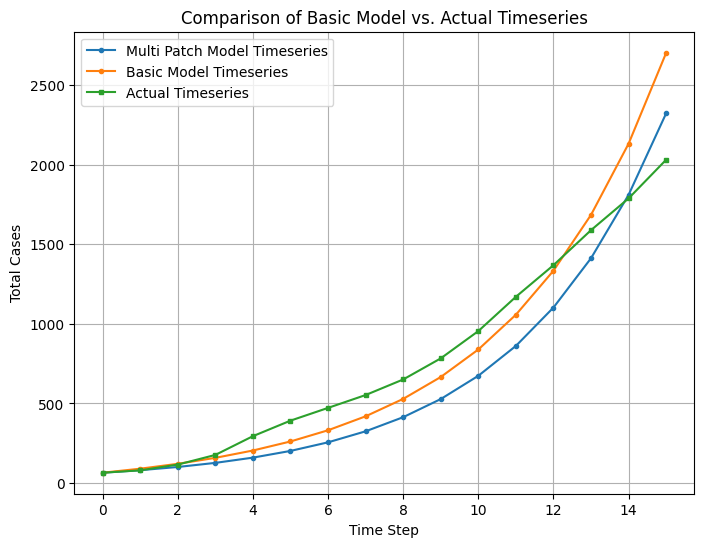

In [17]:
# Plot error for the whole city with basic method
extracted_sol = np.transpose(sol, (1, 2, 0))[2]

total_model_timeseries = np.sum(extracted_sol,axis=0)
total_timeseries = np.sum(all_station_timeseries,axis=0)
print(total_model_timeseries.shape,total_timeseries.shape)

model_sol = np.sum(solution_model[2],axis=0)


# Plot the two time series against each other
plt.figure(figsize=(8, 6))
plt.plot(model_sol, label="Multi Patch Model Timeseries", linestyle='-', marker='o', markersize=3)
plt.plot(total_model_timeseries, label="Basic Model Timeseries", linestyle='-', marker='o', markersize=3)
plt.plot(total_timeseries, label="Actual Timeseries", linestyle='-', marker='s', markersize=3)

# Labels and legend
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.title("Comparison of Basic Model vs. Actual Timeseries")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

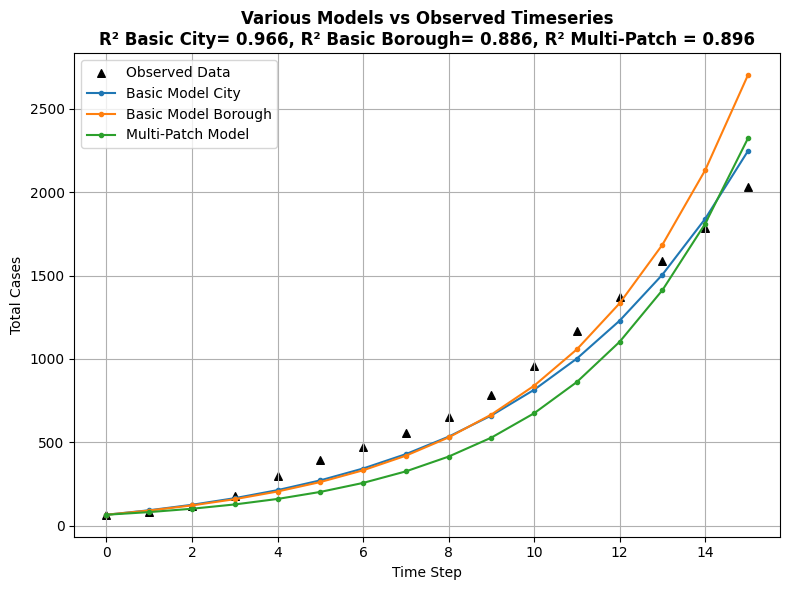

In [18]:
from sklearn.metrics import r2_score

# Extract and sum time series data
extracted_sol = np.transpose(sol, (1, 2, 0))[2]
extracted_sol2 = np.transpose(sol2, (1, 2, 0))[2]
basic_model_ts = np.sum(extracted_sol, axis=0)
basic_model_ts2 = np.sum(extracted_sol2, axis=0)
actual_ts = np.sum(all_station_timeseries, axis=0)
multi_patch_ts = np.sum(solution_model[2], axis=0)


# Compute R² values
r2_basic = r2_score(actual_ts, basic_model_ts)
r2_basic2 = r2_score(actual_ts, basic_model_ts2)
r2_multi = r2_score(actual_ts, multi_patch_ts)

# Plot time series comparison
plt.figure(figsize=(8, 6))
plt.scatter(range(len(actual_ts)), actual_ts, label="Observed Data", marker='^', s=30, color='black')
plt.plot(basic_model_ts2, label="Basic Model City", linestyle='-', marker='o', markersize=3)
plt.plot(basic_model_ts, label="Basic Model Borough", linestyle='-', marker='o', markersize=3)
plt.plot(multi_patch_ts, label="Multi-Patch Model", linestyle='-', marker='o', markersize=3)



# Labeling and legend
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.title(f"Various Models vs Observed Timeseries\n"
          f"R² Basic City= {r2_basic2:.3f}, R² Basic Borough= {r2_basic:.3f}, R² Multi-Patch = {r2_multi:.3f}",fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


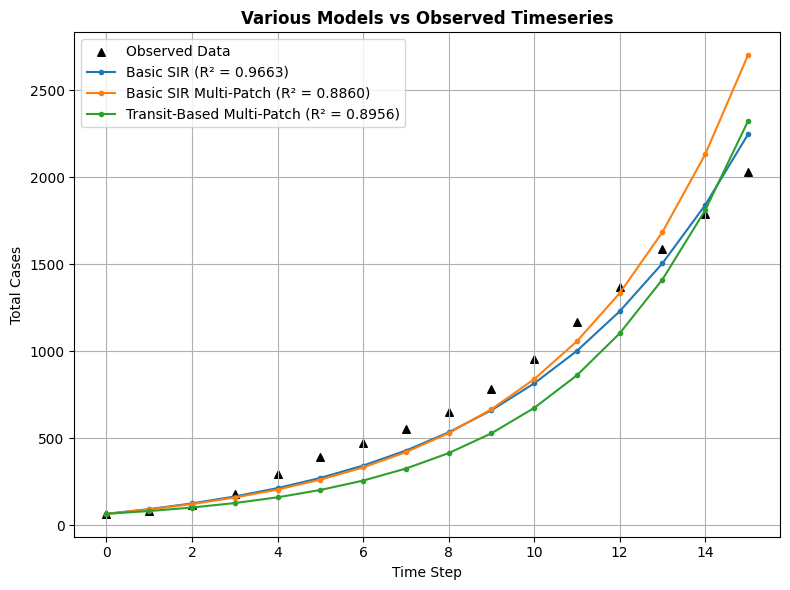

In [20]:
from sklearn.metrics import r2_score

# Extract and sum time series data
extracted_sol = np.transpose(sol, (1, 2, 0))[2]
extracted_sol2 = np.transpose(sol2, (1, 2, 0))[2]
basic_model_ts = np.sum(extracted_sol, axis=0)
basic_model_ts2 = np.sum(extracted_sol2, axis=0)
actual_ts = np.sum(all_station_timeseries, axis=0)
multi_patch_ts = np.sum(solution_model[2], axis=0)

# Compute R² values
r2_basic = r2_score(actual_ts, basic_model_ts)
r2_basic2 = r2_score(actual_ts, basic_model_ts2)
r2_multi = r2_score(actual_ts, multi_patch_ts)

# Plot time series comparison
plt.figure(figsize=(8, 6))
plt.scatter(range(len(actual_ts)), actual_ts, label="Observed Data", marker='^', s=30, color='black')
plt.plot(basic_model_ts2, label=f"Basic SIR (R² = {r2_basic2:.4f})", linestyle='-', marker='o', markersize=3)
plt.plot(basic_model_ts, label=f"Basic SIR Multi-Patch (R² = {r2_basic:.4f})", linestyle='-', marker='o', markersize=3)
plt.plot(multi_patch_ts, label=f"Transit-Based Multi-Patch (R² = {r2_multi:.4f})", linestyle='-', marker='o', markersize=3)

# Labeling and legend
plt.xlabel("Time Step")
plt.ylabel("Total Cases")
plt.title("Various Models vs Observed Timeseries", fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
